# Wifi Fingerprinting

In [591]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier as dtree
from sklearn.neighbors import KNeighborsClassifier as knn
from sklearn.ensemble import RandomForestClassifier as rfc
from sklearn.ensemble import RandomForestRegressor as rfr
from sklearn.linear_model import LinearRegression as lm
from sklearn.ensemble import GradientBoostingClassifier as gbc
from sklearn.ensemble import GradientBoostingRegressor as gbr
from sklearn.metrics import accuracy_score, cohen_kappa_score, confusion_matrix, mean_squared_error, mean_absolute_error, r2_score
from working_funcs import rotate_x, rotate_both, to_perc_neg, to_perc
import plotly.express as px
import plotly.graph_objects as go
from plotnine import ggplot, geom_jitter, aes, geom_point, geom_boxplot, geom_histogram, geom_col, labs, facet_wrap, theme, geom_text, element_text, element_blank, geom_vline, geom_hline

##### Reading raw data

In [442]:
training = pd.read_csv("/Users/tslilstrauss/Google Drive/Strawberry Plate/Data Analysis/Ubiqum Data Analysis/WiFi/Data/Raw/trainingData.csv")
validation = pd.read_csv("/Users/tslilstrauss/Google Drive/Strawberry Plate/Data Analysis/Ubiqum Data Analysis/WiFi/Data/Raw/validationData.csv")

In [443]:
training['TIMESTAMP'] = pd.to_datetime(training['TIMESTAMP'], unit = 's')
training=training.rename(columns = {'TIMESTAMP':'DATETIME'})

validation['TIMESTAMP'] = pd.to_datetime(validation['TIMESTAMP'], unit = 's')
validation=validation.rename(columns = {'TIMESTAMP':'DATETIME'})

In [731]:
training.head()

,WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,WAP007,WAP008,WAP009,WAP010,...,WAP520,LONGITUDE,LATITUDE,FLOOR,BUILDINGID,SPACEID,RELATIVEPOSITION,USERID,PHONEID,DATETIME
0,100,100,100,100,100,100,100,100,100,100,...,100,-7541.2643,4.864921e+06,2,1,106,2,2,23,2013-06-20 07:35:33
1,100,100,100,100,100,100,100,100,100,100,...,100,-7536.6212,4.864934e+06,2,1,106,2,2,23,2013-06-20 07:34:51
2,100,100,100,100,100,100,100,-97,100,100,...,100,-7519.1524,4.864950e+06,2,1,103,2,2,23,2013-06-20 07:41:35
3,100,100,100,100,100,100,100,100,100,100,...,100,-7524.5704,4.864934e+06,2,1,102,2,2,23,2013-06-20 07:36:47
4,100,100,100,100,100,100,100,100,100,100,...,100,-7632.1436,4.864982e+06,0,0,122,2,11,13,2013-05-30 10:28:30


In [ ]:
validation

## About the problem

### Can WiFi finger-printing be used to perform indoor-positioning?

Input - training dataset of ~20k rows of data\
\
Each Row represents a phone in a certain location, and described by the signal strength it recieves from each router (WAP), as well as other charectristics:

* User ID
* Phone ID
* Timestamp
* Real coordinates (x, y, z and building)

### Goal

Creating a model which could get a reading of signal strengths from a user, and pinpoint his location (x, y, z coordinates) within a 2M radius, with an accuracy of at least 50%

### Plotting the training set

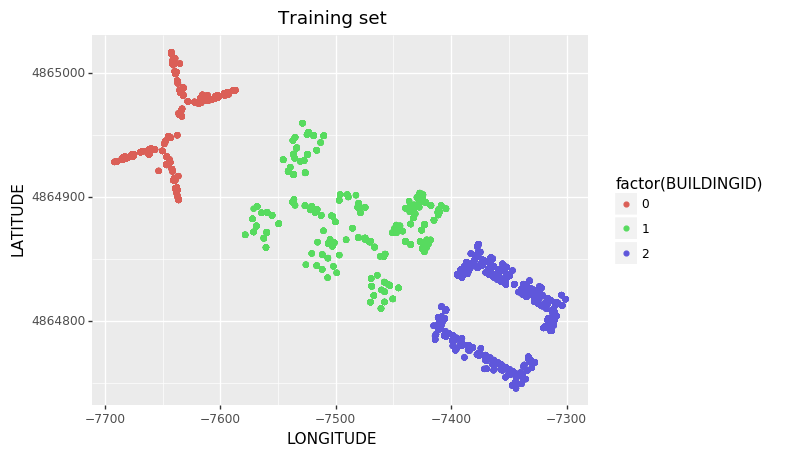

<ggplot: (7358868385)>

In [709]:
ggplot(training, aes(x = "LONGITUDE", y = "LATITUDE", color = "factor(BUILDINGID)")) + geom_point() + labs(title = "Training set")

## Iteration 1: Out of the box

* Building and Floor: Decision Tree
* Latitude and Longitude: Linear Regression
* Subset: All WAPs
* NA Handling: None (keep as 100)
* Pre-process: None

## Training

### Training Building model

In [444]:
WAPS_only = training.loc[:, "WAP001":"WAP520"] #Dataframe with aonly WAP columns
WAPS_ALL = WAPS_only.columns                   #All WAP index
data = WAPS_only
target = training["BUILDINGID"]
data_train, data_test, target_train, target_test = train_test_split(data, target, test_size = 0.30, random_state = 10)
tuned_parameters = {'criterion': ['gini'], 'splitter': ['random'],
                     'random_state': [123], 'min_samples_split': [2]}
building_model = GridSearchCV(dtree(), tuned_parameters)
building_model.fit(data_train, target_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'criterion': ['gini'], 'min_samples_split': [2],
 

### Training Floor model

In [445]:
data = WAPS_only
target = training["FLOOR"]
data_train, data_test, target_train, target_test = train_test_split(data, target, test_size = 0.30, random_state = 10)
tuned_parameters = {'criterion': ['gini'], 'splitter': ['random'],
                     'random_state': [123], 'min_samples_split': [2]}
floor_model = GridSearchCV(dtree(), tuned_parameters)
floor_model.fit(data_train, target_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'criterion': ['gini'], 'min_samples_split': [2],
 

### Training Latitude model

In [446]:
data = WAPS_only
target = training["LATITUDE"]
data_train, data_test, target_train, target_test = train_test_split(data, target, test_size = 0.30, random_state = 10)
tuned_parameters = {'fit_intercept': [True], 'normalize': [False]}
latitude_model = GridSearchCV(lm(), tuned_parameters)
latitude_model.fit(data_train, target_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=LinearRegression(copy_X=True, fit_intercept=True,
                                        n_jobs=None, normalize=False),
             iid='deprecated', n_jobs=None,
             param_grid={'fit_intercept': [True], 'normalize': [False]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

### Training Longitude model

In [447]:
data = WAPS_only
target = training["LONGITUDE"]
data_train, data_test, target_train, target_test = train_test_split(data, target, test_size = 0.30, random_state = 10)
tuned_parameters = {'fit_intercept': [True], 'normalize': [False]}
longitude_model = GridSearchCV(lm(), tuned_parameters)
longitude_model.fit(data_train, target_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=LinearRegression(copy_X=True, fit_intercept=True,
                                        n_jobs=None, normalize=False),
             iid='deprecated', n_jobs=None,
             param_grid={'fit_intercept': [True], 'normalize': [False]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

## Predicting

In [448]:
data_vd = validation[WAPS_ALL]
predicted_building = building_model.predict(data_vd)
predicted_floor = floor_model.predict(data_vd)
predicted_latitude = latitude_model.predict(data_vd)
predicted_longitude = longitude_model.predict(data_vd)

#### Storing in a single DF

In [449]:
df = pd.DataFrame({"pre_building": predicted_building,
                   "pre_floor": predicted_floor,
                   "pre_latitude": predicted_latitude,
                   "pre_longitude": predicted_longitude,
                   "building": validation["BUILDINGID"],
                   "floor": validation["FLOOR"],
                   "latitude": validation["LATITUDE"],
                   "longitude": validation["LONGITUDE"]})

df['err_building'] = df['building'] - df['pre_building']
df['err_floor'] = df['floor'] - df['pre_floor']
df['err_latitude'] = df['latitude'] - df['pre_latitude']
df['err_longitude'] = df['longitude'] - df['pre_longitude']
df['err_position'] = np.sqrt(df['err_longitude']**2 + df['err_latitude']**2)

### Metrics

In [450]:
met = {
    "building": {"accuracy": accuracy_score(df["building"], df["pre_building"]),
                 "kappa": cohen_kappa_score(df["building"], df["pre_building"]),
                 "confusion_matrix": confusion_matrix(df["building"], df["pre_building"])
                },
    "floor": {"accuracy": accuracy_score(df["floor"], df["pre_floor"]),
                 "kappa": cohen_kappa_score(df["floor"], df["pre_floor"]),
                 "confusion_matrix": confusion_matrix(df["floor"], df["pre_floor"])
             },
    "latitude": {"r2": r2_score(df["latitude"], df["pre_latitude"]),
                 "MAE": mean_absolute_error(df["latitude"], df["pre_latitude"]),
                 "RMSE": mean_squared_error(df["latitude"], df["pre_latitude"], squared = False),
                 "Under2m": (abs(df['err_latitude'])<2).sum()/(abs(df['err_latitude'])<2).count()*100
                },
    "longitude": {"r2": r2_score(df["longitude"], df["pre_longitude"]),
                 "MAE": mean_absolute_error(df["longitude"], df["pre_longitude"]),
                 "RMSE": mean_squared_error(df["longitude"], df["pre_longitude"], squared = False),
                 "Under2m": (abs(df['err_longitude'])<2).sum()/(abs(df['err_longitude'])<2).count()*100
                },
    "position": {"Under2m": (abs(df['err_position'])<2).sum()/(abs(df['err_position'])<2).count()*100
    }
}

In [451]:
print("BUILDING")
print("________")
print()
print(f"Accuracy: {met['building']['accuracy']:.2f}")
print(f"Kappa:    {met['building']['kappa']:.2f}")
print()
print(f"Confusion Matrix: \n\n{met['building']['confusion_matrix']}")
print()
print("FLOOR")
print("______")
print()
print(f"Accuracy: {met['floor']['accuracy']:.2f}")
print(f"Kappa:    {met['floor']['kappa']:.2f}")
print()
print(f"Confusion Matrix: \n\n{met['floor']['confusion_matrix']}")
print()
print("LATITUDE")
print("________")
print()
print(f"r2:       {met['latitude']['r2']:.2f}")
print(f"RMSE:     {met['latitude']['RMSE']:.2f}")
print(f"MAE:      {met['latitude']['MAE']:.2f}")
print(f"Under 2:  {met['latitude']['Under2m']:.2f}%")
print()
print("LONGITUDE")
print("_________")
print()
print(f"r2:       {met['longitude']['r2']:.2f}")
print(f"RMSE:     {met['longitude']['RMSE']:.2f}")
print(f"MAE:      {met['longitude']['MAE']:.2f}")
print(f"Under 2:  {met['longitude']['Under2m']:.2f}%")
print()
print("POSITION")
print("_________")
print()
print(f"Under 2:  {met['position']['Under2m']:.2f}%")
print()

BUILDING
________

Accuracy: 0.99
Kappa:    0.99

Confusion Matrix: 

[[532   4   0]
 [  1 304   2]
 [  0   3 265]]

FLOOR
______

Accuracy: 0.72
Kappa:    0.63

Confusion Matrix: 

[[114  11   6   1   0]
 [ 63 320  69   9   1]
 [  9  22 214  61   0]
 [  0   5  20 142   5]
 [  2   0   3  19  15]]

LATITUDE
________

r2:       -2646920672591194624.00
RMSE:     114277880566.20
MAE:      4996538796.85
Under 2:  5.40%

LONGITUDE
_________

r2:       -366047463652026482688.00
RMSE:     2298853834205.11
MAE:      100512122527.29
Under 2:  2.43%

POSITION
_________

Under 2:  0.36%



### Plotting

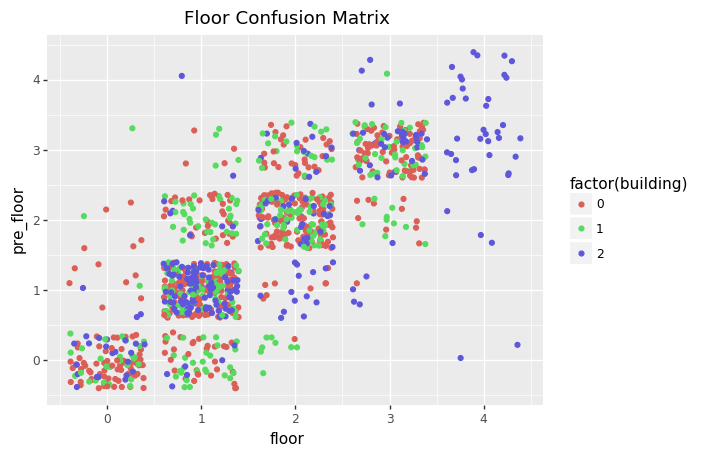

<ggplot: (7127536793)>

In [452]:
ggplot(df, aes(x = "floor", y = "pre_floor", color = "factor(building)")) + geom_jitter() + labs(title = "Floor Confusion Matrix")

## Floor Iteration 2: Reduce Dimensionality by RSSI Values

* Floor: Decision Tree
* Subset: WAPS RSSI >-50 (= 215 WAPS)
* NA Handling: None (keep as 100)
* Pre-process: None

In [453]:
# Creating df with WAPs as row index - and column counting all non 100 (=relevant) values
WAP_cond = pd.DataFrame(WAPS_only[WAPS_only != 100].count(), columns=["#Relevant_Values"])

# Creating columns with amount of readings over a certain value, for values between -100 and 0
for v in range(-100, 0, 10):
    WAP_cond[f"#over{v}"] = WAP_cond["#Relevant_Values"] - WAPS_only[WAPS_only < v].count()

We count the amount of relevant RSSI Values per WAP

In [454]:
WAP_cond

,#Relevant_Values,#over-100,#over-90,#over-80,#over-70,#over-60,#over-50,#over-40,#over-30,#over-20,#over-10
WAP001,18,18,0,0,0,0,0,0,0,0,0
WAP002,19,19,19,0,0,0,0,0,0,0,0
WAP003,0,0,0,0,0,0,0,0,0,0,0
WAP004,0,0,0,0,0,0,0,0,0,0,0
WAP005,40,40,8,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
WAP516,3038,3037,2812,1919,1273,597,226,60,17,14,12
WAP517,4543,4542,4226,2744,1167,439,130,48,22,22,15
WAP518,22,22,8,0,0,0,0,0,0,0,0
WAP519,3,3,0,0,0,0,0,0,0,0,0


#### We save 'WAPS_50' - WAPS from the training set which recieved at least a single value over -50

In [455]:
WAPS_50 = WAPS_only[(WAPS_only!=100) & (WAPS_only>=-50)].dropna(how = 'all', axis = 1).columns #WAPs with at least one reading of over -50 

### Training Floor model

In [456]:
data = WAPS_only[WAPS_50]

In [457]:
target = training["FLOOR"]
data_train, data_test, target_train, target_test = train_test_split(data, target, test_size = 0.30, random_state = 10)
tuned_parameters = {'criterion': ['gini'], 'splitter': ['random'],
                     'random_state': [123], 'min_samples_split': [2]}
floor_model = GridSearchCV(dtree(), tuned_parameters)
floor_model.fit(data_train, target_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'criterion': ['gini'], 'min_samples_split': [2],
 

In [458]:
data_vd = validation[WAPS_50]
predicted_floor = floor_model.predict(data_vd)

#### Storing in a single DF

In [459]:
df = pd.DataFrame({"pre_building": predicted_building,
                   "pre_floor": predicted_floor,
                   "pre_latitude": predicted_latitude,
                   "pre_longitude": predicted_longitude,
                   "building": validation["BUILDINGID"],
                   "floor": validation["FLOOR"],
                   "latitude": validation["LATITUDE"],
                   "longitude": validation["LONGITUDE"]})

df['err_building'] = df['building'] - df['pre_building']
df['err_floor'] = df['floor'] - df['pre_floor']
df['err_latitude'] = df['latitude'] - df['pre_latitude']
df['err_longitude'] = df['longitude'] - df['pre_longitude']
df['err_position'] = np.sqrt(df['err_longitude']**2 + df['err_latitude']**2)

### Metrics

In [460]:
met = {
    "building": {"accuracy": accuracy_score(df["building"], df["pre_building"]),
                 "kappa": cohen_kappa_score(df["building"], df["pre_building"]),
                 "confusion_matrix": confusion_matrix(df["building"], df["pre_building"])
                },
    "floor": {"accuracy": accuracy_score(df["floor"], df["pre_floor"]),
                 "kappa": cohen_kappa_score(df["floor"], df["pre_floor"]),
                 "confusion_matrix": confusion_matrix(df["floor"], df["pre_floor"])
             },
    "latitude": {"r2": r2_score(df["latitude"], df["pre_latitude"]),
                 "MAE": mean_absolute_error(df["latitude"], df["pre_latitude"]),
                 "RMSE": mean_squared_error(df["latitude"], df["pre_latitude"], squared = False),
                 "Under2m": (abs(df['err_latitude'])<2).sum()/(abs(df['err_latitude'])<2).count()*100
                },
    "longitude": {"r2": r2_score(df["longitude"], df["pre_longitude"]),
                 "MAE": mean_absolute_error(df["longitude"], df["pre_longitude"]),
                 "RMSE": mean_squared_error(df["longitude"], df["pre_longitude"], squared = False),
                 "Under2m": (abs(df['err_longitude'])<2).sum()/(abs(df['err_longitude'])<2).count()*100
                },
    "position": {"Under2m": (abs(df['err_position'])<2).sum()/(abs(df['err_position'])<2).count()*100
    }
}

In [710]:
print('''
FLOOR - Iteration 1
___________________

Accuracy: 0.72
Kappa:    0.63

Confusion Matrix: 

[[114  11   6   1   0]
 [ 63 320  69   9   1]
 [  9  22 214  61   0]
 [  0   5  20 142   5]
 [  2   0   3  19  15]]
''')


FLOOR - Iteration 1
___________________

Accuracy: 0.72
Kappa:    0.63

Confusion Matrix: 

[[114  11   6   1   0]
 [ 63 320  69   9   1]
 [  9  22 214  61   0]
 [  0   5  20 142   5]
 [  2   0   3  19  15]]



In [461]:
print("FLOOR")
print("______")
print()
print(f"Accuracy: {met['floor']['accuracy']:.2f}")
print(f"Kappa:    {met['floor']['kappa']:.2f}")
print()
print(f"Confusion Matrix: \n\n{met['floor']['confusion_matrix']}")

FLOOR
______

Accuracy: 0.75
Kappa:    0.66

Confusion Matrix: 

[[106  11   6   9   0]
 [ 37 327  79  19   0]
 [  4  18 236  48   0]
 [  1   1  21 148   1]
 [  0   0   0  25  14]]


### Plotting

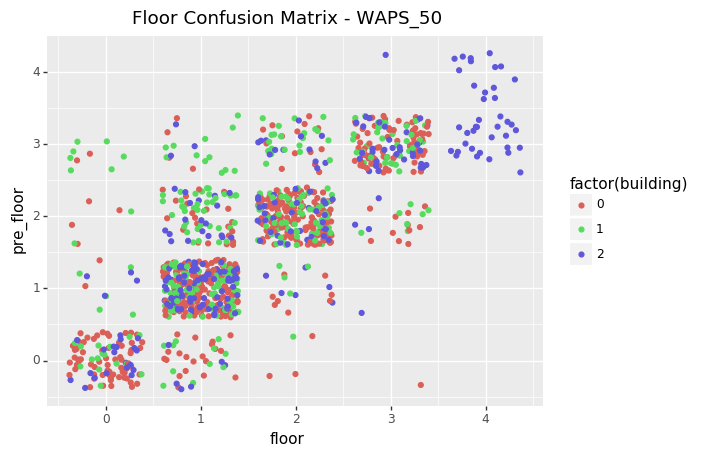

<ggplot: (7106526933)>

In [462]:
ggplot(df, aes(x = "floor", y = "pre_floor", color = "factor(building)")) + geom_jitter() + labs(title = "Floor Confusion Matrix - WAPS_50")

### WAPs Distribution

In [463]:
# making a copy of training and validation
df1 = training.copy()

# replacing all 100 with np.nan
df1 = df1.replace(to_replace = 100, value = np.nan)

# storing a list of WAPs over -50 from training
WAPS_under_50 = df1[WAPS_ALL][df1[WAPS_ALL] >- 50].dropna(how = 'all', axis = 1).columns

# adding extra column BUILDING, etc..
WAPS_under_50 = list(WAPS_under_50) + ["BUILDINGID", "FLOOR"]

# Subsetting with WAPs over -50 FROM TRINING SET
wap_df = df1[WAPS_under_50]

WAP_dist = wap_df.groupby(["BUILDINGID", "FLOOR"]).aggregate("count")

WAP_dist = pd.DataFrame(WAP_dist.replace(to_replace = 0, value = np.nan).dropna(thresh = 1).stack())

WAP_dist.reset_index(inplace=True)
WAP_dist.columns = ['BUILDINGID', 'FLOOR', 'WAP', 'COUNT']

full_wap_dist = WAP_dist.copy()

for wap in WAPS_ALL:
    if wap not in WAP_dist.WAP.values:
        full_wap_dist = full_wap_dist.append({'BUILDINGID': 'NA', 'FLOOR': 'NA', 'BG-FLOOR': 'NA', 'WAP': wap, 'COUNT': 0}, ignore_index=True)

#### WAP distribution per building

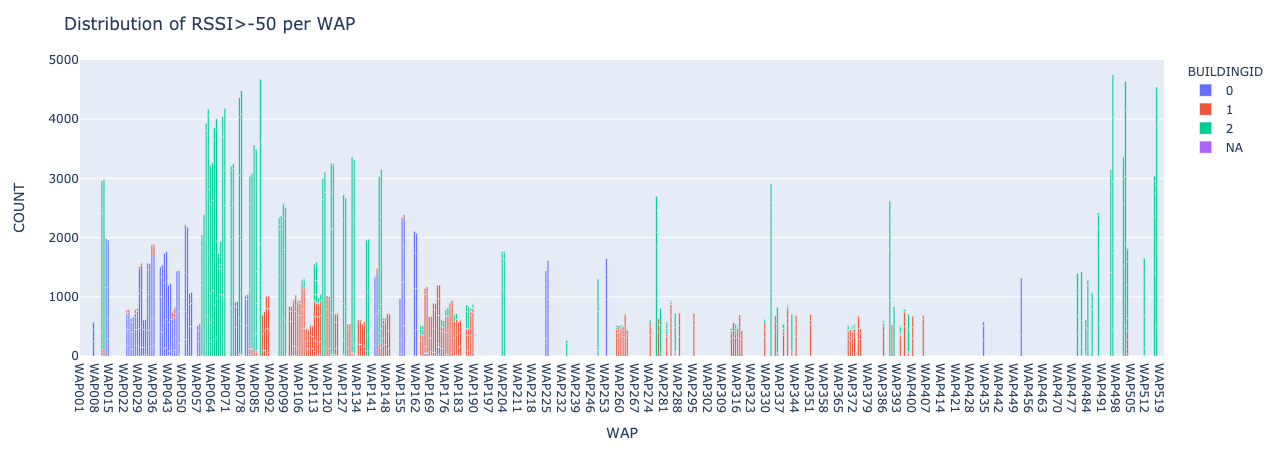

In [464]:
fig = px.bar(full_wap_dist, x = 'WAP', y = 'COUNT', color = 'BUILDINGID')
fig.update_layout(title = "Distribution of RSSI>-50 per WAP", barmode='relative', xaxis={'categoryorder':'category ascending'})
fig.show()

#### WAP distribution per floor - Each Building

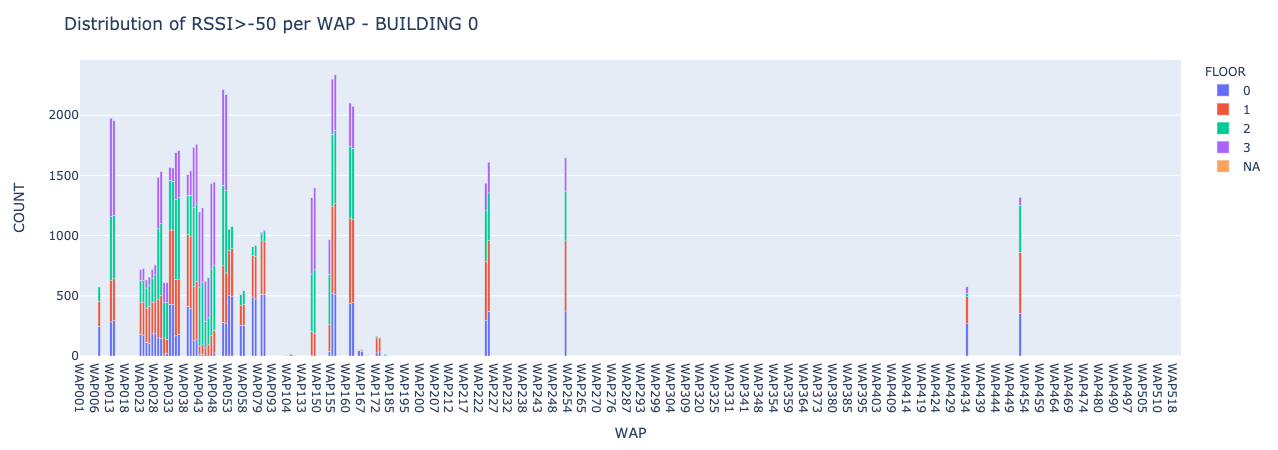

In [465]:
fig = px.bar(full_wap_dist[(full_wap_dist.BUILDINGID == 0) | (full_wap_dist.BUILDINGID == 'NA')], x = 'WAP', y = 'COUNT', color = 'FLOOR')
fig.update_layout(title = "Distribution of RSSI>-50 per WAP - BUILDING 0", barmode='relative', xaxis={'categoryorder':'category ascending'})
fig.show()

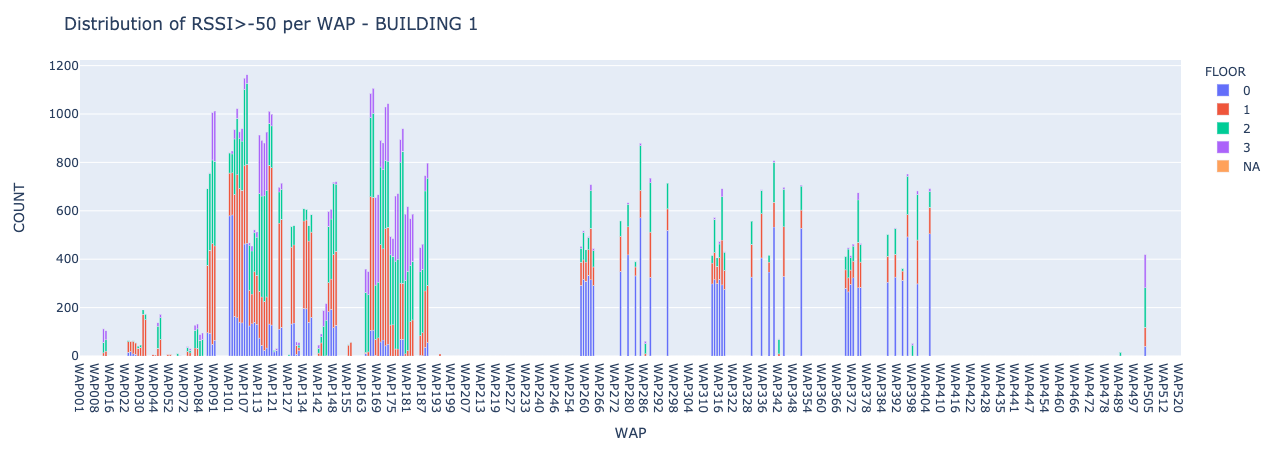

In [466]:
fig = px.bar(full_wap_dist[(full_wap_dist.BUILDINGID == 1) | (full_wap_dist.BUILDINGID == 'NA')], x = 'WAP', y = 'COUNT', color = 'FLOOR')
fig.update_layout(title = "Distribution of RSSI>-50 per WAP - BUILDING 1", barmode='relative', xaxis={'categoryorder':'category ascending'})
fig.show()

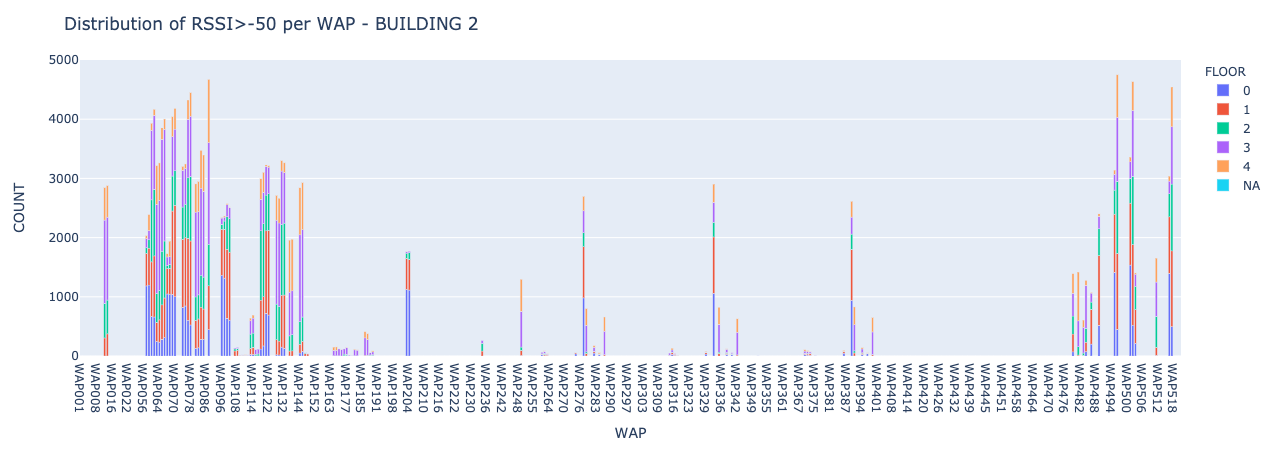

In [467]:
fig = px.bar(full_wap_dist[(full_wap_dist.BUILDINGID == 2) | (full_wap_dist.BUILDINGID == 'NA')], x = 'WAP', y = 'COUNT', color = 'FLOOR')
fig.update_layout(title = "Distribution of RSSI>-50 per WAP - BUILDING 2", barmode='relative', xaxis={'categoryorder':'category ascending'})
fig.show()

We save:
* 'WAPS_id200' - WAPS from the training set which recieved at least a single value over -50 AND with a number <200
* 'WAPS_50_id200' - WAPS from the training set which recieved at least a single value over -50 AND with a number <200

In [469]:
WAPS_id200 = WAPS_only.loc[:,"WAP001":"WAP200"].columns #WAP# under 200
WAPS_50_id200 = WAPS_50.intersection(WAPS_id200) #Intersection of both #<200 and RSSI value>-50

## Floor Iteration 3 - Reduce dimensionality by RSSI Values AND WAP# (distribution)

* Floor: Decision Tree
* Subset: WAPS RSSI >-50 & WAP#<200 ( = 164 WAPs)
* NA Handling: None (keep as 100)
* Pre-process: None

In [468]:
# Creating df with WAPs as row index - and column counting all non 100 (=relevant) values
WAP_cond = pd.DataFrame(WAPS_only[WAPS_only != 100].count(), columns=["#Relevant_Values"])

# Creating columns with amount of readings over a certain value, for values between -100 and 0
for v in range(-100, 0, 10):
    WAP_cond[f"#over{v}"] = WAP_cond["#Relevant_Values"] - WAPS_only[WAPS_only < v].count()

### Training Floor model

In [470]:
data = WAPS_only[WAPS_50_id200]

In [471]:
target = training["FLOOR"]
data_train, data_test, target_train, target_test = train_test_split(data, target, test_size = 0.30, random_state = 10)
tuned_parameters = {'criterion': ['gini'], 'splitter': ['random'],
                     'random_state': [123], 'min_samples_split': [2]}
floor_model = GridSearchCV(dtree(), tuned_parameters)
floor_model.fit(data_train, target_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'criterion': ['gini'], 'min_samples_split': [2],
 

### Predicting Floor

In [472]:
data_vd = validation[WAPS_50_id200]
predicted_floor = floor_model.predict(data_vd)

#### Storing in a single DF

In [473]:
df = pd.DataFrame({"pre_building": predicted_building,
                   "pre_floor": predicted_floor,
                   "pre_latitude": predicted_latitude,
                   "pre_longitude": predicted_longitude,
                   "building": validation["BUILDINGID"],
                   "floor": validation["FLOOR"],
                   "latitude": validation["LATITUDE"],
                   "longitude": validation["LONGITUDE"]})

df['err_building'] = df['building'] - df['pre_building']
df['err_floor'] = df['floor'] - df['pre_floor']
df['err_latitude'] = df['latitude'] - df['pre_latitude']
df['err_longitude'] = df['longitude'] - df['pre_longitude']
df['err_position'] = np.sqrt(df['err_longitude']**2 + df['err_latitude']**2)

### Metrics

In [474]:
met = {
    "building": {"accuracy": accuracy_score(df["building"], df["pre_building"]),
                 "kappa": cohen_kappa_score(df["building"], df["pre_building"]),
                 "confusion_matrix": confusion_matrix(df["building"], df["pre_building"])
                },
    "floor": {"accuracy": accuracy_score(df["floor"], df["pre_floor"]),
                 "kappa": cohen_kappa_score(df["floor"], df["pre_floor"]),
                 "confusion_matrix": confusion_matrix(df["floor"], df["pre_floor"])
             },
    "latitude": {"r2": r2_score(df["latitude"], df["pre_latitude"]),
                 "MAE": mean_absolute_error(df["latitude"], df["pre_latitude"]),
                 "RMSE": mean_squared_error(df["latitude"], df["pre_latitude"], squared = False),
                 "Under2m": (abs(df['err_latitude'])<2).sum()/(abs(df['err_latitude'])<2).count()*100
                },
    "longitude": {"r2": r2_score(df["longitude"], df["pre_longitude"]),
                 "MAE": mean_absolute_error(df["longitude"], df["pre_longitude"]),
                 "RMSE": mean_squared_error(df["longitude"], df["pre_longitude"], squared = False),
                 "Under2m": (abs(df['err_longitude'])<2).sum()/(abs(df['err_longitude'])<2).count()*100
                },
    "position": {"Under2m": (abs(df['err_position'])<2).sum()/(abs(df['err_position'])<2).count()*100
    }
}

In [475]:
print('''
FLOOR - Iteration 2 Metrics
___________________________

Accuracy: 0.75
Kappa:    0.66

Confusion Matrix: 

[[106  11   6   9   0]
 [ 37 327  79  19   0]
 [  4  18 236  48   0]
 [  1   1  21 148   1]
 [  0   0   0  25  14]]
''')


FLOOR - Iteration 2 Metrics
___________________________

Accuracy: 0.75
Kappa:    0.66

Confusion Matrix: 

[[106  11   6   9   0]
 [ 37 327  79  19   0]
 [  4  18 236  48   0]
 [  1   1  21 148   1]
 [  0   0   0  25  14]]



In [476]:
print("FLOOR - Iteration 3 Metrics")
print("___________________________")
print()
print(f"Accuracy: {met['floor']['accuracy']:.2f}")
print(f"Kappa:    {met['floor']['kappa']:.2f}")
print()
print(f"Confusion Matrix: \n\n{met['floor']['confusion_matrix']}")

FLOOR - Iteration 3 Metrics
___________________________

Accuracy: 0.77
Kappa:    0.69

Confusion Matrix: 

[[111  16   3   2   0]
 [ 50 333  71   8   0]
 [  6  20 245  32   3]
 [  4   3  11 148   6]
 [  2   0   0  15  22]]


### Plotting

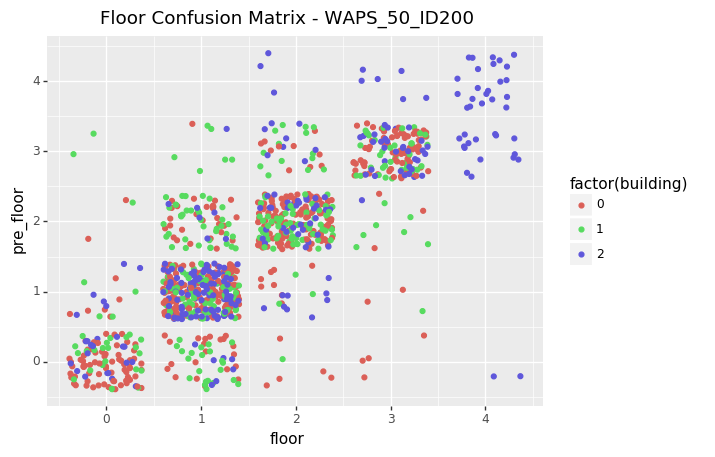

<ggplot: (7107333853)>

In [477]:
ggplot(df, aes(x = "floor", y = "pre_floor", color = "factor(building)")) + geom_jitter() + labs(title = "Floor Confusion Matrix - WAPS_50_ID200")

## Floor Iteration 4 - NA Values

* Floor: Decision Tree
* Subset: WAPS RSSI >-50 & WAP#<200 ( = 164 WAPs)
* NA Handling: transform to -200
* Pre-process: None

In [478]:
data = data.replace(to_replace = 100, value = -200)

### Training Floor model

In [479]:
target = training["FLOOR"]
data_train, data_test, target_train, target_test = train_test_split(data, target, test_size = 0.30, random_state = 10)
tuned_parameters = {'criterion': ['gini'], 'splitter': ['random'],
                     'random_state': [123], 'min_samples_split': [2]}
floor_model = GridSearchCV(dtree(), tuned_parameters)
floor_model.fit(data_train, target_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'criterion': ['gini'], 'min_samples_split': [2],
 

### Predicting Floor

In [480]:
data_vd = data_vd.replace(to_replace=100, value=-200)

In [481]:
predicted_floor = floor_model.predict(data_vd)

#### Storing in a single DF

In [482]:
df = pd.DataFrame({"pre_building": predicted_building,
                   "pre_floor": predicted_floor,
                   "pre_latitude": predicted_latitude,
                   "pre_longitude": predicted_longitude,
                   "building": validation["BUILDINGID"],
                   "floor": validation["FLOOR"],
                   "latitude": validation["LATITUDE"],
                   "longitude": validation["LONGITUDE"]})

df['err_building'] = df['building'] - df['pre_building']
df['err_floor'] = df['floor'] - df['pre_floor']
df['err_latitude'] = df['latitude'] - df['pre_latitude']
df['err_longitude'] = df['longitude'] - df['pre_longitude']
df['err_position'] = np.sqrt(df['err_longitude']**2 + df['err_latitude']**2)

### Metrics

In [483]:
met = {
    "building": {"accuracy": accuracy_score(df["building"], df["pre_building"]),
                 "kappa": cohen_kappa_score(df["building"], df["pre_building"]),
                 "confusion_matrix": confusion_matrix(df["building"], df["pre_building"])
                },
    "floor": {"accuracy": accuracy_score(df["floor"], df["pre_floor"]),
                 "kappa": cohen_kappa_score(df["floor"], df["pre_floor"]),
                 "confusion_matrix": confusion_matrix(df["floor"], df["pre_floor"])
             },
    "latitude": {"r2": r2_score(df["latitude"], df["pre_latitude"]),
                 "MAE": mean_absolute_error(df["latitude"], df["pre_latitude"]),
                 "RMSE": mean_squared_error(df["latitude"], df["pre_latitude"], squared = False),
                 "Under2m": (abs(df['err_latitude'])<2).sum()/(abs(df['err_latitude'])<2).count()*100
                },
    "longitude": {"r2": r2_score(df["longitude"], df["pre_longitude"]),
                 "MAE": mean_absolute_error(df["longitude"], df["pre_longitude"]),
                 "RMSE": mean_squared_error(df["longitude"], df["pre_longitude"], squared = False),
                 "Under2m": (abs(df['err_longitude'])<2).sum()/(abs(df['err_longitude'])<2).count()*100
                },
    "position": {"Under2m": (abs(df['err_position'])<2).sum()/(abs(df['err_position'])<2).count()*100
    }
}

In [484]:
print('''
FLOOR - Iteration 3 Metrics
___________________________

Accuracy: 0.77
Kappa:    0.69

Confusion Matrix: 

[[111  16   3   2   0]
 [ 50 333  71   8   0]
 [  6  20 245  32   3]
 [  4   3  11 148   6]
 [  2   0   0  15  22]]
''')


FLOOR - Iteration 3 Metrics
___________________________

Accuracy: 0.77
Kappa:    0.69

Confusion Matrix: 

[[111  16   3   2   0]
 [ 50 333  71   8   0]
 [  6  20 245  32   3]
 [  4   3  11 148   6]
 [  2   0   0  15  22]]



In [485]:
print("FLOOR - Iteration 4 Metrics")
print("___________________________")
print()
print(f"Accuracy: {met['floor']['accuracy']:.2f}")
print(f"Kappa:    {met['floor']['kappa']:.2f}")
print()
print(f"Confusion Matrix: \n\n{met['floor']['confusion_matrix']}")

FLOOR - Iteration 4 Metrics
___________________________

Accuracy: 0.81
Kappa:    0.74

Confusion Matrix: 

[[109  14   6   3   0]
 [ 36 373  47   6   0]
 [  3  19 248  36   0]
 [  1   4  16 148   3]
 [  2   0   0  16  21]]


### Plotting

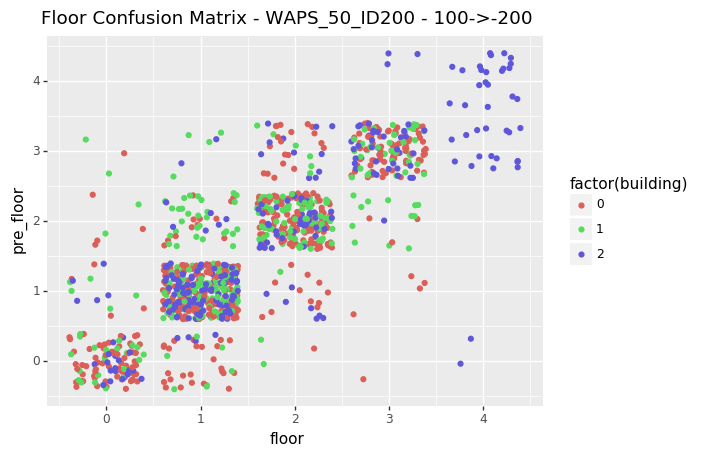

<ggplot: (7107344845)>

In [486]:
ggplot(df, aes(x = "floor", y = "pre_floor", color = "factor(building)")) + geom_jitter() + labs(title = "Floor Confusion Matrix - WAPS_50_ID200 - 100->-200")

## Latitude-Longitude Iteration 2: Log transform

* Longitute + Latitude: Linear Regression
* Subset: WAP#<200
* NA Handling: 100 -> 0
* Pre-process: Log transform

### Training Latitude model

In [487]:
data = training[WAPS_id200].copy()
# All 100 to 0, all other log_transform
data.mask(data==100, 0, inplace=True)
data.mask((data!=100) & (data !=0), 10.0**(data/10), inplace=True)

In [488]:
target = training["LATITUDE"]

In [489]:
data_train, data_test, target_train, target_test = train_test_split(data, target, test_size = 0.30, random_state = 10)
tuned_parameters = {'fit_intercept': [True], 'normalize': [False]}
latitude_model = GridSearchCV(lm(), tuned_parameters)
latitude_model.fit(data_train, target_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=LinearRegression(copy_X=True, fit_intercept=True,
                                        n_jobs=None, normalize=False),
             iid='deprecated', n_jobs=None,
             param_grid={'fit_intercept': [True], 'normalize': [False]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

### Training Longitude model

In [490]:
data = training[WAPS_id200].copy()
# All 100 to -10, all other log_transform
data.mask(data==100, 0, inplace=True)
data.mask((data!=100) & (data !=0), 10.0**(data/10), inplace=True)

In [491]:
target = training["LONGITUDE"]

In [492]:
data_train, data_test, target_train, target_test = train_test_split(data, target, test_size = 0.30, random_state = 10)
tuned_parameters = {'fit_intercept': [True], 'normalize': [False]}
longitude_model = GridSearchCV(lm(), tuned_parameters)
longitude_model.fit(data_train, target_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=LinearRegression(copy_X=True, fit_intercept=True,
                                        n_jobs=None, normalize=False),
             iid='deprecated', n_jobs=None,
             param_grid={'fit_intercept': [True], 'normalize': [False]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

### Predicting Longitude & Latitude

In [493]:
data_vd = validation[WAPS_id200].copy()
# All 100 to -10, all other log_transform
data_vd.mask(data_vd==100, 0, inplace=True)
data_vd.mask((data_vd!=100) & (data_vd !=0), 10.0**(data_vd/10), inplace=True)

In [494]:
predicted_latitude = latitude_model.predict(data_vd)
predicted_longitude = longitude_model.predict(data_vd)

#### Storing in a single DF

In [495]:
df = pd.DataFrame({"pre_building": predicted_building,
                   "pre_floor": predicted_floor,
                   "pre_latitude": predicted_latitude,
                   "pre_longitude": predicted_longitude,
                   "building": validation["BUILDINGID"],
                   "floor": validation["FLOOR"],
                   "latitude": validation["LATITUDE"],
                   "longitude": validation["LONGITUDE"]})

df['err_building'] = df['building'] - df['pre_building']
df['err_floor'] = df['floor'] - df['pre_floor']
df['err_latitude'] = df['latitude'] - df['pre_latitude']
df['err_longitude'] = df['longitude'] - df['pre_longitude']
df['err_position'] = np.sqrt(df['err_longitude']**2 + df['err_latitude']**2)

### Metrics

In [496]:
met = {
    "building": {"accuracy": accuracy_score(df["building"], df["pre_building"]),
                 "kappa": cohen_kappa_score(df["building"], df["pre_building"]),
                 "confusion_matrix": confusion_matrix(df["building"], df["pre_building"])
                },
    "floor": {"accuracy": accuracy_score(df["floor"], df["pre_floor"]),
                 "kappa": cohen_kappa_score(df["floor"], df["pre_floor"]),
                 "confusion_matrix": confusion_matrix(df["floor"], df["pre_floor"])
             },
    "latitude": {"r2": r2_score(df["latitude"], df["pre_latitude"]),
                 "MAE": mean_absolute_error(df["latitude"], df["pre_latitude"]),
                 "RMSE": mean_squared_error(df["latitude"], df["pre_latitude"], squared = False),
                 "Under2m": (abs(df['err_latitude'])<2).sum()/(abs(df['err_latitude'])<2).count()*100
                },
    "longitude": {"r2": r2_score(df["longitude"], df["pre_longitude"]),
                 "MAE": mean_absolute_error(df["longitude"], df["pre_longitude"]),
                 "RMSE": mean_squared_error(df["longitude"], df["pre_longitude"], squared = False),
                 "Under2m": (abs(df['err_longitude'])<2).sum()/(abs(df['err_longitude'])<2).count()*100
                },
    "position": {"Under2m": (abs(df['err_position'])<2).sum()/(abs(df['err_position'])<2).count()*100
    }
}

In [500]:
print("LATITUDE")
print("________")
print()
print(f"r2:       {met['latitude']['r2']:.2f}")
print(f"RMSE:     {met['latitude']['RMSE']:.2f}")
print(f"MAE:      {met['latitude']['MAE']:.2f}")
print(f"Under 2:  {met['latitude']['Under2m']:.2f}%")
print()
print("LONGITUDE")
print("_________")
print()
print(f"r2:       {met['longitude']['r2']:.2f}")
print(f"RMSE:     {met['longitude']['RMSE']:.2f}")
print(f"MAE:      {met['longitude']['MAE']:.2f}")
print(f"Under 2:  {met['longitude']['Under2m']:.2f}%")
print()
print("POSITION")
print("________")
print()
print(f"Under 2:  {met['position']['Under2m']:.2f}%")

LATITUDE
________

r2:       -4.30
RMSE:     161.70
MAE:      77.54
Under 2:  2.07%

LONGITUDE
_________

r2:       -6.30
RMSE:     324.59
MAE:      147.59
Under 2:  0.63%

POSITION
________

Under 2:  0.00%


### Plotting

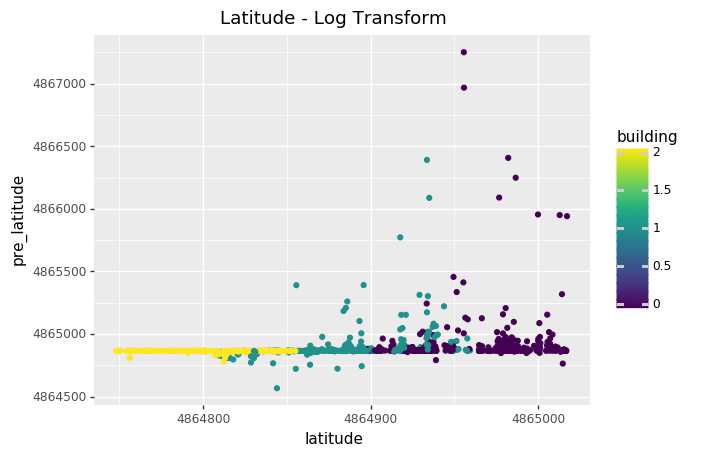

<ggplot: (7107337485)>

In [498]:
ggplot(df, aes(x = "latitude", y = "pre_latitude", color = "building")) + geom_point() + labs(title = "Latitude - Log Transform")

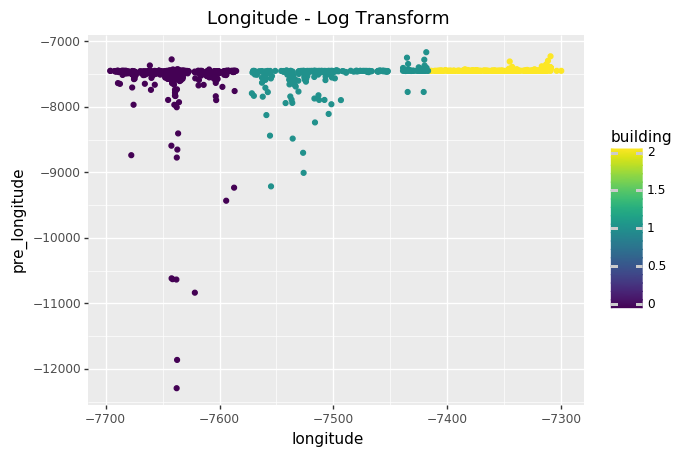

<ggplot: (7029588313)>

In [499]:
ggplot(df, aes(x = "longitude", y = "pre_longitude", color = "building")) + geom_point() + labs(title = "Longitude - Log Transform")

## Latitude-Longitude Iteration 3: Random Forest

* Longitute + Latitude: Random Forest
* Subset: WAP#<200
* NA Handling: 100 -> 0
* Pre-process: Log transform

### Training Latitude model

In [502]:
target = training["LATITUDE"]

In [503]:
data_train, data_test, target_train, target_test = train_test_split(data, target, test_size = 0.30, random_state = 10)
tuned_parameters = {'n_estimators': [10], 'random_state': [123]}
latitude_model = GridSearchCV(rfr(), tuned_parameters)
latitude_model.fit(data_train, target_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n

### Training Longitude model

In [504]:
target = training["LONGITUDE"]

In [505]:
data_train, data_test, target_train, target_test = train_test_split(data, target, test_size = 0.30, random_state = 10)
tuned_parameters = {'n_estimators': [10], 'random_state': [123]}
longitude_model = GridSearchCV(rfr(), tuned_parameters)
longitude_model.fit(data_train, target_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n

### Predicting Longitude & Latitude

In [506]:
predicted_latitude = latitude_model.predict(data_vd)
predicted_longitude = longitude_model.predict(data_vd)

#### Storing in a single DF

In [507]:
df = pd.DataFrame({"pre_building": predicted_building,
                   "pre_floor": predicted_floor,
                   "pre_latitude": predicted_latitude,
                   "pre_longitude": predicted_longitude,
                   "building": validation["BUILDINGID"],
                   "floor": validation["FLOOR"],
                   "latitude": validation["LATITUDE"],
                   "longitude": validation["LONGITUDE"]})

df['err_building'] = df['building'] - df['pre_building']
df['err_floor'] = df['floor'] - df['pre_floor']
df['err_latitude'] = df['latitude'] - df['pre_latitude']
df['err_longitude'] = df['longitude'] - df['pre_longitude']
df['err_position'] = np.sqrt(df['err_longitude']**2 + df['err_latitude']**2)

### Metrics

In [508]:
met = {
    "building": {"accuracy": accuracy_score(df["building"], df["pre_building"]),
                 "kappa": cohen_kappa_score(df["building"], df["pre_building"]),
                 "confusion_matrix": confusion_matrix(df["building"], df["pre_building"])
                },
    "floor": {"accuracy": accuracy_score(df["floor"], df["pre_floor"]),
                 "kappa": cohen_kappa_score(df["floor"], df["pre_floor"]),
                 "confusion_matrix": confusion_matrix(df["floor"], df["pre_floor"])
             },
    "latitude": {"r2": r2_score(df["latitude"], df["pre_latitude"]),
                 "MAE": mean_absolute_error(df["latitude"], df["pre_latitude"]),
                 "RMSE": mean_squared_error(df["latitude"], df["pre_latitude"], squared = False),
                 "Under2m": (abs(df['err_latitude'])<2).sum()/(abs(df['err_latitude'])<2).count()*100
                },
    "longitude": {"r2": r2_score(df["longitude"], df["pre_longitude"]),
                 "MAE": mean_absolute_error(df["longitude"], df["pre_longitude"]),
                 "RMSE": mean_squared_error(df["longitude"], df["pre_longitude"], squared = False),
                 "Under2m": (abs(df['err_longitude'])<2).sum()/(abs(df['err_longitude'])<2).count()*100
                },
    "position": {"Under2m": (abs(df['err_position'])<2).sum()/(abs(df['err_position'])<2).count()*100
    }
}

In [509]:
print("LATITUDE")
print("________")
print()
print(f"r2:       {met['latitude']['r2']:.2f}")
print(f"RMSE:     {met['latitude']['RMSE']:.2f}")
print(f"MAE:      {met['latitude']['MAE']:.2f}")
print(f"Under 2:  {met['latitude']['Under2m']:.2f}%")
print()
print("LONGITUDE")
print("_________")
print()
print(f"r2:       {met['longitude']['r2']:.2f}")
print(f"RMSE:     {met['longitude']['RMSE']:.2f}")
print(f"MAE:      {met['longitude']['MAE']:.2f}")
print(f"Under 2:  {met['longitude']['Under2m']:.2f}%")
print()
print("POSITION")
print("________")
print()
print(f"Under 2:  {met['position']['Under2m']:.2f}%")

LATITUDE
________

r2:       0.71
RMSE:     37.83
MAE:      20.58
Under 2:  23.85%

LONGITUDE
_________

r2:       0.67
RMSE:     69.48
MAE:      34.89
Under 2:  24.84%

POSITION
________

Under 2:  9.63%


### Plotting

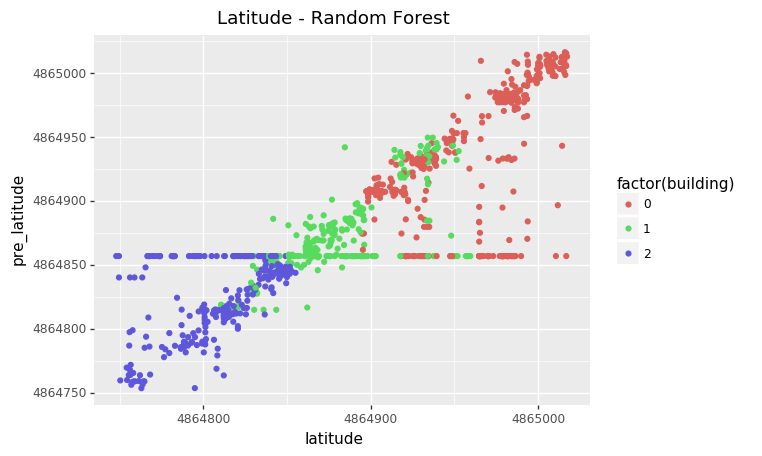

<ggplot: (7029402633)>

In [510]:
ggplot(df, aes(x = "latitude", y = "pre_latitude", color = "factor(building)")) + geom_point() + labs(title = "Latitude - Random Forest")

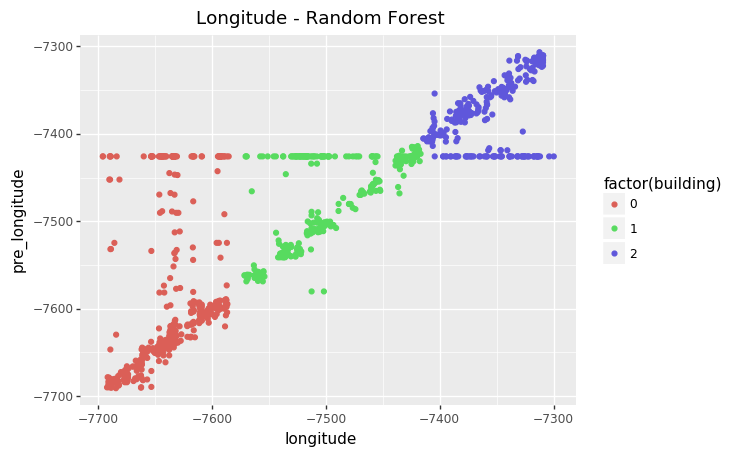

<ggplot: (7029904217)>

In [511]:
ggplot(df, aes(x = "longitude", y = "pre_longitude", color = "factor(building)")) + geom_point() + labs(title = "Longitude - Random Forest")

## Focus on strange output

* We pick the suspicious coordinates from the predicted coordinates
* We isolate the same coordinates in the training set and look for strong common denominators


In [213]:
line = training[(training['LATITUDE'] < 4864860) & (training['LATITUDE'] > 4864850) & (training['LONGITUDE'] < -7410) & (training['LONGITUDE'] > -7440)]

In [214]:
phone_count = line.groupby('PHONEID').aggregate({"DATETIME": 'count'}).reset_index()

In [215]:
phone_count

,PHONEID,DATETIME
0,14,50


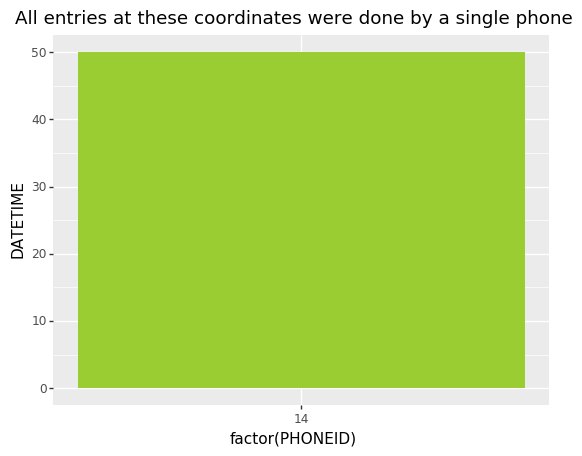

<ggplot: (7068405377)>

In [286]:
ggplot(phone_count, aes(x = "factor(PHONEID)", y = "DATETIME")) + geom_col(fill = "yellowgreen") + labs(title = "All entries at these coordinates were done by a single phone")

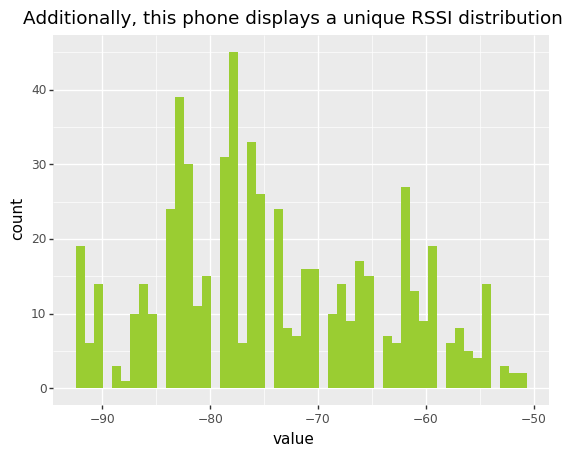

<ggplot: (7069849921)>

In [279]:
ggplot(line[WAPS_ALL].replace(to_replace = 100, value = np.nan).melt().dropna(), aes(x = "value")) + geom_histogram(bins = 50, fill = 'yellowgreen') + labs(title = "Additionally, this phone displays a unique RSSI distribution")

## Looking at distribution per Phone

In [56]:
na_tr = training.replace(to_replace=100, value=np.nan)

In [57]:
WAP_PHONE = na_tr.loc[:,WAPS_ALL]
WAP_PHONE["PHONEID"] = na_tr["PHONEID"]

In [58]:
phones = {}
for x in set(WAP_PHONE["PHONEID"]):
    temp = WAP_PHONE[WAP_PHONE["PHONEID"] == x].drop("PHONEID", axis =1).values
    temp = temp[~np.isnan(temp)]
    phones[f"PHONE{x}"] = temp

In [59]:
phones_df = pd.DataFrame.from_dict(phones, orient = 'index').reset_index()
phones_df_melt = phones_df.melt(id_vars = 'index')
phones_df_melt.columns = ['PHONEID', 'TEMP', 'RSSI']
phones_df_melt = phones_df_melt.drop("TEMP", axis = 1).dropna()

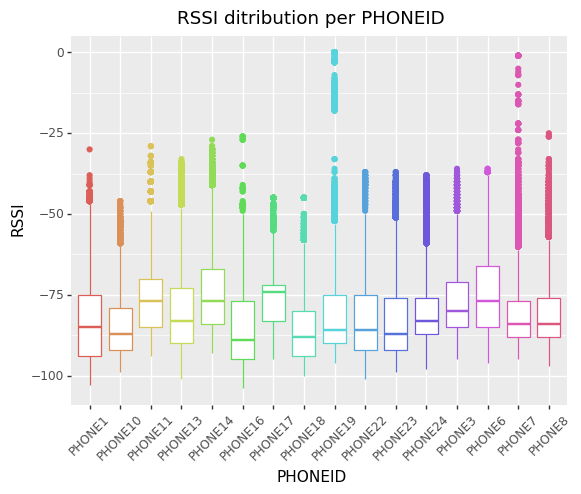

<ggplot: (7283269589)>

In [290]:
(ggplot(phones_df_melt, aes(x = 'PHONEID', y = 'RSSI', color = 'factor(PHONEID)')) +
 geom_boxplot(show_legend=False) +
 theme(axis_text_x=element_text(angle = 45)) +
 labs(title = "RSSI ditribution per PHONEID")
)

### Normalizing as % of maximum value in row

In [62]:
norm_WAP_PHONE = WAP_PHONE[WAPS_ALL].copy()
norm_WAP_PHONE = norm_WAP_PHONE.replace(to_replace=np.nan, value = -105)
norm_WAP_PHONE = norm_WAP_PHONE - 100
norm_WAP_PHONE = norm_WAP_PHONE.apply(to_perc_neg, axis = 0, args = [-205])
norm_WAP_PHONE["PHONEID"] = na_tr["PHONEID"]

In [63]:
norm_phones = {}
for x in set(norm_WAP_PHONE["PHONEID"]):
    temp = norm_WAP_PHONE[norm_WAP_PHONE["PHONEID"] == x].drop("PHONEID", axis =1).values
    temp = temp[~np.isnan(temp)]
    norm_phones[f"PHONE{x}"] = temp

In [64]:
norm_phones_df = pd.DataFrame.from_dict(norm_phones, orient = 'index').reset_index()
norm_phones_df_melt = norm_phones_df.melt(id_vars = 'index')
norm_phones_df_melt.columns = ['PHONEID', 'TEMP', 'RSSI']
norm_phones_df_melt = norm_phones_df_melt.drop("TEMP", axis = 1)
norm_phones_df_melt = norm_phones_df_melt.replace(to_replace = 0, value = np.nan).dropna()

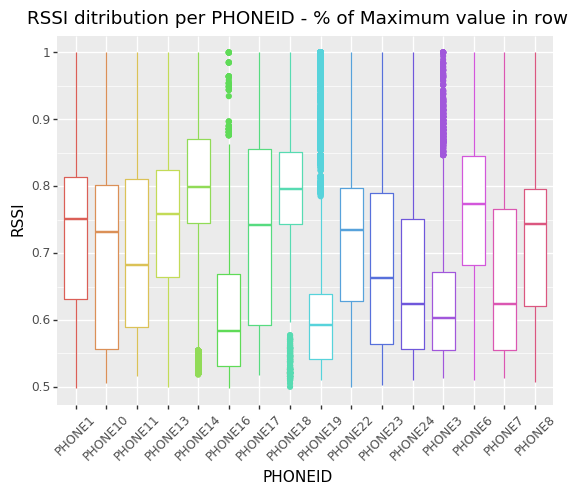

<ggplot: (7283209257)>

In [291]:
(ggplot(norm_phones_df_melt, aes(x = 'PHONEID', y = 'RSSI', color = 'factor(PHONEID)')) +
 geom_boxplot(show_legend=False) +
 theme(axis_text_x=element_text(angle = 45)) +
 labs(title = "RSSI ditribution per PHONEID - % of Maximum value in row")
)

### Normalizing between min and max

In [66]:
MM_WAP_PHONE = WAP_PHONE[WAPS_ALL].copy()

In [67]:
scaler = MinMaxScaler()

In [68]:
scaler.fit(MM_WAP_PHONE.T)

/Users/tslilstrauss/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:375: RuntimeWarning:

All-NaN slice encountered

/Users/tslilstrauss/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:376: RuntimeWarning:

All-NaN slice encountered



MinMaxScaler(copy=True, feature_range=(0, 1))

In [69]:
MM_WAP_PHONE = pd.DataFrame(scaler.transform(MM_WAP_PHONE.T), index=MM_WAP_PHONE.T.index).T
MM_WAP_PHONE["PHONEID"] = training["PHONEID"]

In [70]:
MM_phones = {}
for x in set(MM_WAP_PHONE["PHONEID"]):
    temp = MM_WAP_PHONE[MM_WAP_PHONE["PHONEID"] == x].drop("PHONEID", axis =1).values
    temp = temp[~np.isnan(temp)]
    MM_phones[f"PHONE{x}"] = temp

In [72]:
MM_phones_df = pd.DataFrame.from_dict(MM_phones, orient = 'index').reset_index()
MM_phones_df_melt = MM_phones_df.melt(id_vars = 'index')
MM_phones_df_melt.columns = ['PHONEID', 'TEMP', 'RSSI']
MM_phones_df_melt = MM_phones_df_melt.drop("TEMP", axis = 1)
MM_phones_df_melt = MM_phones_df_melt.replace(to_replace = 0, value = np.nan).dropna()

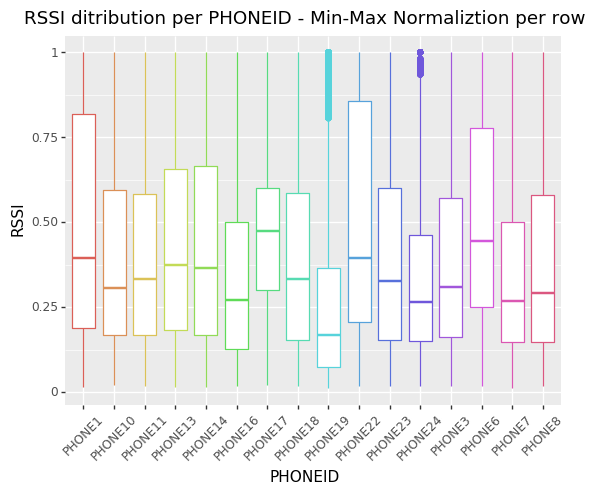

<ggplot: (7283200109)>

In [292]:
(ggplot(MM_phones_df_melt, aes(x = 'PHONEID', y = 'RSSI', color = 'factor(PHONEID)')) +
 geom_boxplot(show_legend=False) +
 theme(axis_text_x=element_text(angle = 45)) +
 labs(title = "RSSI ditribution per PHONEID - Min-Max Normaliztion per row")
)

## Latitude-Longitude Iteration 4: Normalized

* Longitute + Latitude: Random Forest
* Subset: WAP#<200
* NA Handling: 100 -> 0
* Pre-process: Log transform + Normalize

### Training Latitude model

In [512]:
target = training["LATITUDE"]

In [513]:
scaler = MinMaxScaler()
scaler.fit(data.T)
data = pd.DataFrame(scaler.transform(data.T).T, index = data.index, columns=data.columns)
data = data.replace(to_replace = np.nan, value = 0)

In [514]:
data_train, data_test, target_train, target_test = train_test_split(data, target, test_size = 0.30, random_state = 10)
tuned_parameters = {'n_estimators': [100], 'random_state': [123]}
latitude_model = GridSearchCV(rfr(), tuned_parameters)
latitude_model.fit(data_train, target_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n

### Training Longitude model

In [515]:
target = training["LONGITUDE"]

In [516]:
data_train, data_test, target_train, target_test = train_test_split(data, target, test_size = 0.30, random_state = 10)
tuned_parameters = {'n_estimators': [100], 'random_state': [123]}
longitude_model = GridSearchCV(rfr(), tuned_parameters)
longitude_model.fit(data_train, target_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n

### Predicting Longitude & Latitude

In [517]:
scaler_vd = MinMaxScaler()
scaler.fit(data_vd.T)
data_vd = pd.DataFrame(scaler.transform(data_vd.T).T, index = data_vd.index, columns=data_vd.columns)
data_vd = data_vd.replace(to_replace = np.nan, value = 0)

In [518]:
predicted_latitude = latitude_model.predict(data_vd)
predicted_longitude = longitude_model.predict(data_vd)

#### Storing in a single DF

In [519]:
df = pd.DataFrame({"pre_building": predicted_building,
                   "pre_floor": predicted_floor,
                   "pre_latitude": predicted_latitude,
                   "pre_longitude": predicted_longitude,
                   "building": validation["BUILDINGID"],
                   "floor": validation["FLOOR"],
                   "latitude": validation["LATITUDE"],
                   "longitude": validation["LONGITUDE"]})

df['err_building'] = df['building'] - df['pre_building']
df['err_floor'] = df['floor'] - df['pre_floor']
df['err_latitude'] = df['latitude'] - df['pre_latitude']
df['err_longitude'] = df['longitude'] - df['pre_longitude']
df['err_position'] = np.sqrt(df['err_longitude']**2 + df['err_latitude']**2)

### Metrics

In [520]:
met = {
    "building": {"accuracy": accuracy_score(df["building"], df["pre_building"]),
                 "kappa": cohen_kappa_score(df["building"], df["pre_building"]),
                 "confusion_matrix": confusion_matrix(df["building"], df["pre_building"])
                },
    "floor": {"accuracy": accuracy_score(df["floor"], df["pre_floor"]),
                 "kappa": cohen_kappa_score(df["floor"], df["pre_floor"]),
                 "confusion_matrix": confusion_matrix(df["floor"], df["pre_floor"])
             },
    "latitude": {"r2": r2_score(df["latitude"], df["pre_latitude"]),
                 "MAE": mean_absolute_error(df["latitude"], df["pre_latitude"]),
                 "RMSE": mean_squared_error(df["latitude"], df["pre_latitude"], squared = False),
                 "Under2m": (abs(df['err_latitude'])<2).sum()/(abs(df['err_latitude'])<2).count()*100
                },
    "longitude": {"r2": r2_score(df["longitude"], df["pre_longitude"]),
                 "MAE": mean_absolute_error(df["longitude"], df["pre_longitude"]),
                 "RMSE": mean_squared_error(df["longitude"], df["pre_longitude"], squared = False),
                 "Under2m": (abs(df['err_longitude'])<2).sum()/(abs(df['err_longitude'])<2).count()*100
                },
    "position": {"Under2m": (abs(df['err_position'])<2).sum()/(abs(df['err_position'])<2).count()*100
    }
}

In [521]:
print("LATITUDE")
print("________")
print()
print(f"r2:       {met['latitude']['r2']:.2f}")
print(f"RMSE:     {met['latitude']['RMSE']:.2f}")
print(f"MAE:      {met['latitude']['MAE']:.2f}")
print(f"Under 2:  {met['latitude']['Under2m']:.2f}%")
print()
print("LONGITUDE")
print("_________")
print()
print(f"r2:       {met['longitude']['r2']:.2f}")
print(f"RMSE:     {met['longitude']['RMSE']:.2f}")
print(f"MAE:      {met['longitude']['MAE']:.2f}")
print(f"Under 2:  {met['longitude']['Under2m']:.2f}%")
print()
print("POSITION")
print("________")
print()
print(f"Under 2:  {met['position']['Under2m']:.2f}%")

LATITUDE
________

r2:       0.97
RMSE:     13.09
MAE:      7.16
Under 2:  30.96%

LONGITUDE
_________

r2:       0.99
RMSE:     13.28
MAE:      8.02
Under 2:  26.01%

POSITION
________

Under 2:  9.45%


### Plotting

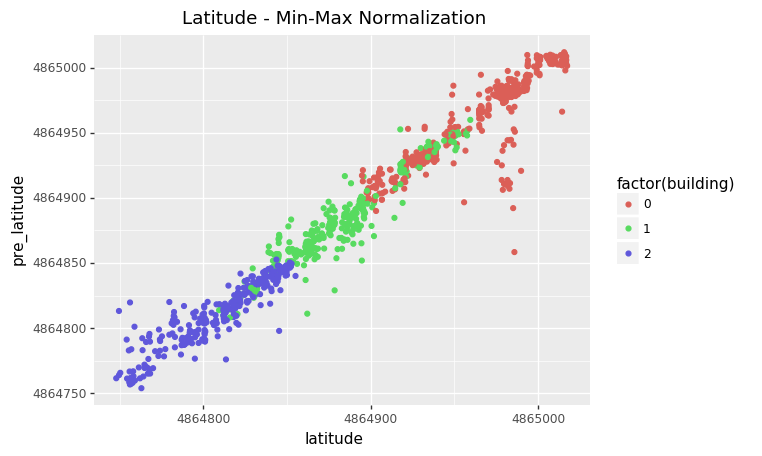

<ggplot: (7030277481)>

In [522]:
ggplot(df, aes(x = "latitude", y = "pre_latitude", color = "factor(building)")) + geom_point() + labs(title = "Latitude - Min-Max Normalization")

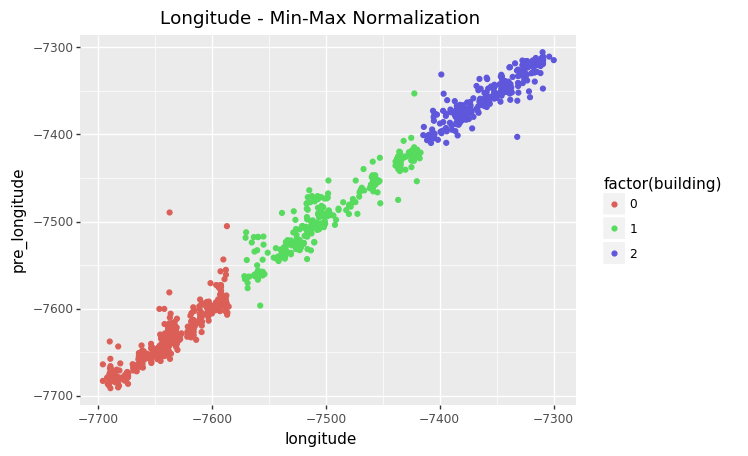

<ggplot: (7030277521)>

In [523]:
ggplot(df, aes(x = "longitude", y = "pre_longitude", color = "factor(building)")) + geom_point() + labs(title = "Longitude - Min-Max Normalization")

## Floor Iteration 5: Min-Max normalize per row

* Floor: Decision Tree
* Subset: WAPS RSSI >-50 & WAP#<200 ( = 164 WAPs)
* NA Handling: transform to 0%
* Pre-process: Min-Max Normalization Per Row

In [524]:
data = training[WAPS_50_id200].replace(to_replace=100, value = np.nan)

In [525]:
scaler = MinMaxScaler()
scaler.fit(data.T)
data = pd.DataFrame(scaler.transform(data.T).T, index = data.index, columns=data.columns)
data = data.replace(to_replace = np.nan, value = 0)

/Users/tslilstrauss/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:375: RuntimeWarning:

All-NaN slice encountered

/Users/tslilstrauss/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:376: RuntimeWarning:

All-NaN slice encountered



### Training Floor model

In [526]:
target = training["FLOOR"]
data_train, data_test, target_train, target_test = train_test_split(data, target, test_size = 0.30, random_state = 10)
tuned_parameters = {'criterion': ['gini'], 'splitter': ['random'],
                     'random_state': [123], 'min_samples_split': [2]}
floor_model = GridSearchCV(dtree(), tuned_parameters)
floor_model.fit(data_train, target_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'criterion': ['gini'], 'min_samples_split': [2],
 

### Predicting Floor

In [527]:
data_vd = validation[WAPS_50_id200].replace(to_replace=100, value = np.nan)

In [528]:
scaler_vd = MinMaxScaler()
scaler.fit(data_vd.T)
data_vd = pd.DataFrame(scaler.transform(data_vd.T).T, index = data_vd.index, columns=data_vd.columns)
data_vd = data_vd.replace(to_replace = np.nan, value = 0)

/Users/tslilstrauss/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:375: RuntimeWarning:

All-NaN slice encountered

/Users/tslilstrauss/opt/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:376: RuntimeWarning:

All-NaN slice encountered



In [529]:
predicted_floor = floor_model.predict(data_vd)

#### Storing in a single DF

In [530]:
df = pd.DataFrame({"pre_building": predicted_building,
                   "pre_floor": predicted_floor,
                   "pre_latitude": predicted_latitude,
                   "pre_longitude": predicted_longitude,
                   "building": validation["BUILDINGID"],
                   "floor": validation["FLOOR"],
                   "latitude": validation["LATITUDE"],
                   "longitude": validation["LONGITUDE"]})

df['err_building'] = df['building'] - df['pre_building']
df['err_floor'] = df['floor'] - df['pre_floor']
df['err_latitude'] = df['latitude'] - df['pre_latitude']
df['err_longitude'] = df['longitude'] - df['pre_longitude']
df['err_position'] = np.sqrt(df['err_longitude']**2 + df['err_latitude']**2)

### Metrics

In [531]:
met = {
    "building": {"accuracy": accuracy_score(df["building"], df["pre_building"]),
                 "kappa": cohen_kappa_score(df["building"], df["pre_building"]),
                 "confusion_matrix": confusion_matrix(df["building"], df["pre_building"])
                },
    "floor": {"accuracy": accuracy_score(df["floor"], df["pre_floor"]),
                 "kappa": cohen_kappa_score(df["floor"], df["pre_floor"]),
                 "confusion_matrix": confusion_matrix(df["floor"], df["pre_floor"])
             },
    "latitude": {"r2": r2_score(df["latitude"], df["pre_latitude"]),
                 "MAE": mean_absolute_error(df["latitude"], df["pre_latitude"]),
                 "RMSE": mean_squared_error(df["latitude"], df["pre_latitude"], squared = False),
                 "Under2m": (abs(df['err_latitude'])<2).sum()/(abs(df['err_latitude'])<2).count()*100
                },
    "longitude": {"r2": r2_score(df["longitude"], df["pre_longitude"]),
                 "MAE": mean_absolute_error(df["longitude"], df["pre_longitude"]),
                 "RMSE": mean_squared_error(df["longitude"], df["pre_longitude"], squared = False),
                 "Under2m": (abs(df['err_longitude'])<2).sum()/(abs(df['err_longitude'])<2).count()*100
                },
    "position": {"Under2m": (abs(df['err_position'])<2).sum()/(abs(df['err_position'])<2).count()*100
    }
}

Before normalization:
* Accuracy: 0.81
* Kappa:    0.74

In [532]:
print("FLOOR")
print("______")
print()
print(f"Accuracy: {met['floor']['accuracy']:.2f}")
print(f"Kappa:    {met['floor']['kappa']:.2f}")
print()
print(f"Confusion Matrix: \n\n{met['floor']['confusion_matrix']}")

FLOOR
______

Accuracy: 0.86
Kappa:    0.81

Confusion Matrix: 

[[109  16   7   0   0]
 [ 24 396  40   2   0]
 [  5  19 268  14   0]
 [  1   0   8 159   4]
 [  6   0   0   6  27]]


### Plotting

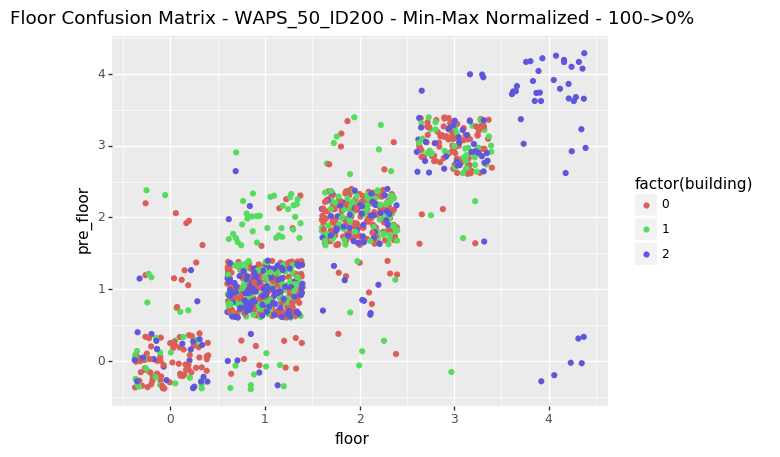

<ggplot: (7030282433)>

In [533]:
ggplot(df, aes(x = "floor", y = "pre_floor", color = "factor(building)")) + geom_jitter() + labs(title = "Floor Confusion Matrix - WAPS_50_ID200 - Min-Max Normalized - 100->0%")

## Floor Iteration 6 - KNN

* Floor: KNN
* Subset: WAPS RSSI >-50 & WAP#<200 ( = 164 WAPs)
* NA Handling: transform to 0%
* Pre-process: Normalizing Min-Max in Row

### Training Floor model

In [536]:
tuned_parameters = {'n_neighbors': [6]}
floor_model = GridSearchCV(knn(), tuned_parameters)
floor_model.fit(data_train, target_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='deprecated', n_jobs=None, param_grid={'n_neighbors': [6]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

### Predicting Floor

In [537]:
predicted_floor = floor_model.predict(data_vd)

#### Storing in a single DF

In [538]:
df = pd.DataFrame({"pre_building": predicted_building,
                   "pre_floor": predicted_floor,
                   "pre_latitude": predicted_latitude,
                   "pre_longitude": predicted_longitude,
                   "building": validation["BUILDINGID"],
                   "floor": validation["FLOOR"],
                   "latitude": validation["LATITUDE"],
                   "longitude": validation["LONGITUDE"]})

df['err_building'] = df['building'] - df['pre_building']
df['err_floor'] = df['floor'] - df['pre_floor']
df['err_latitude'] = df['latitude'] - df['pre_latitude']
df['err_longitude'] = df['longitude'] - df['pre_longitude']
df['err_position'] = np.sqrt(df['err_longitude']**2 + df['err_latitude']**2)

### Metrics

In [539]:
met = {
    "building": {"accuracy": accuracy_score(df["building"], df["pre_building"]),
                 "kappa": cohen_kappa_score(df["building"], df["pre_building"]),
                 "confusion_matrix": confusion_matrix(df["building"], df["pre_building"])
                },
    "floor": {"accuracy": accuracy_score(df["floor"], df["pre_floor"]),
                 "kappa": cohen_kappa_score(df["floor"], df["pre_floor"]),
                 "confusion_matrix": confusion_matrix(df["floor"], df["pre_floor"])
             },
    "latitude": {"r2": r2_score(df["latitude"], df["pre_latitude"]),
                 "MAE": mean_absolute_error(df["latitude"], df["pre_latitude"]),
                 "RMSE": mean_squared_error(df["latitude"], df["pre_latitude"], squared = False),
                 "Under2m": (abs(df['err_latitude'])<2).sum()/(abs(df['err_latitude'])<2).count()*100
                },
    "longitude": {"r2": r2_score(df["longitude"], df["pre_longitude"]),
                 "MAE": mean_absolute_error(df["longitude"], df["pre_longitude"]),
                 "RMSE": mean_squared_error(df["longitude"], df["pre_longitude"], squared = False),
                 "Under2m": (abs(df['err_longitude'])<2).sum()/(abs(df['err_longitude'])<2).count()*100
                },
    "position": {"Under2m": (abs(df['err_position'])<2).sum()/(abs(df['err_position'])<2).count()*100
    }
}

In [540]:
print('''
FLOOR - Iteration 5 Metrics
___________________________

Accuracy: 0.86
Kappa:    0.81

Confusion Matrix: 

[[109  16   7   0   0]
 [ 24 396  40   2   0]
 [  5  19 268  14   0]
 [  1   0   8 159   4]
 [  6   0   0   6  27]]
''')


FLOOR - Iteration 5 Metrics
___________________________

Accuracy: 0.86
Kappa:    0.81

Confusion Matrix: 

[[109  16   7   0   0]
 [ 24 396  40   2   0]
 [  5  19 268  14   0]
 [  1   0   8 159   4]
 [  6   0   0   6  27]]



In [541]:
print("FLOOR - Iteration 6 Metrics")
print("___________________________")
print()
print(f"Accuracy: {met['floor']['accuracy']:.2f}")
print(f"Kappa:    {met['floor']['kappa']:.2f}")
print()
print(f"Confusion Matrix: \n\n{met['floor']['confusion_matrix']}")

FLOOR - Iteration 6 Metrics
___________________________

Accuracy: 0.93
Kappa:    0.91

Confusion Matrix: 

[[112  15   4   1   0]
 [ 19 434   9   0   0]
 [  2   8 292   4   0]
 [  3   0   4 165   0]
 [  0   0   0   4  35]]


### Plotting

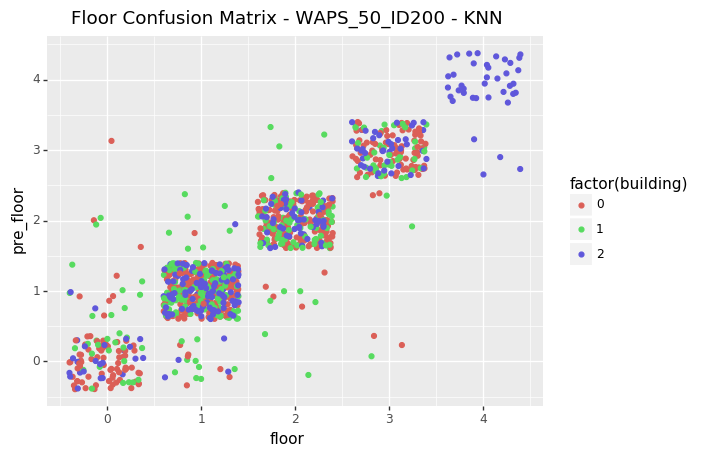

<ggplot: (7032597089)>

In [542]:
ggplot(df, aes(x = "floor", y = "pre_floor", color = "factor(building)")) + geom_jitter() + labs(title = "Floor Confusion Matrix - WAPS_50_ID200 - KNN")

## Building - Iteration 2: Subset + Log + Normalization

### Training Building

In [543]:
data = training[WAPS_50_id200].copy()
target = training["BUILDINGID"]

In [544]:
# All 100 to -10, all other log_transform
data.mask(data==100, 0, inplace=True)
data.mask((data!=100) & (data !=0), 10.0**(data/10), inplace=True)

In [545]:
scaler = MinMaxScaler()
scaler.fit(data.T)
data = pd.DataFrame(scaler.transform(data.T).T, index = data.index, columns=data.columns)
data = data.replace(to_replace = np.nan, value = 0)

In [546]:
data_train, data_test, target_train, target_test = train_test_split(data, target, test_size = 0.30, random_state = 10)

In [547]:
tuned_parameters = {'criterion': ['gini'], 'splitter': ['random'],
                     'random_state': [123], 'min_samples_split': [2]}

In [548]:
building_model = GridSearchCV(dtree(), tuned_parameters)

In [549]:
building_model.fit(data_train, target_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'criterion': ['gini'], 'min_samples_split': [2],
 

### Predicting Building

In [550]:
data_vd = validation[WAPS_50_id200].copy()

In [551]:
# All 100 to -10, all other log_transform
data_vd.mask(data_vd==100, 0, inplace=True)
data_vd.mask((data_vd!=100) & (data_vd !=0), 10.0**(data_vd/10), inplace=True)

In [552]:
scaler_vd = MinMaxScaler()
scaler.fit(data_vd.T)
data_vd = pd.DataFrame(scaler.transform(data_vd.T).T, index = data_vd.index, columns=data_vd.columns)
data_vd = data_vd.replace(to_replace = np.nan, value = 0)

In [553]:
predicted_building = building_model.predict(data_vd)

#### Storing in a single DF

In [554]:
df = pd.DataFrame({"pre_building": predicted_building,
                   "pre_floor": predicted_floor,
                   "pre_latitude": predicted_latitude,
                   "pre_longitude": predicted_longitude,
                   "building": validation["BUILDINGID"],
                   "floor": validation["FLOOR"],
                   "latitude": validation["LATITUDE"],
                   "longitude": validation["LONGITUDE"]})

In [555]:
df['err_building'] = df['building'] - df['pre_building']
df['err_floor'] = df['floor'] - df['pre_floor']
df['err_latitude'] = df['latitude'] - df['pre_latitude']
df['err_longitude'] = df['longitude'] - df['pre_longitude']
df['err_position'] = np.sqrt(df['err_longitude']**2 + df['err_latitude']**2)

### Metrics

In [556]:
met = {
    "building": {"accuracy": accuracy_score(df["building"], df["pre_building"]),
                 "kappa": cohen_kappa_score(df["building"], df["pre_building"]),
                 "confusion_matrix": confusion_matrix(df["building"], df["pre_building"])
                },
    "floor": {"accuracy": accuracy_score(df["floor"], df["pre_floor"]),
                 "kappa": cohen_kappa_score(df["floor"], df["pre_floor"]),
                 "confusion_matrix": confusion_matrix(df["floor"], df["pre_floor"])
             },
    "latitude": {"r2": r2_score(df["latitude"], df["pre_latitude"]),
                 "MAE": mean_absolute_error(df["latitude"], df["pre_latitude"]),
                 "RMSE": mean_squared_error(df["latitude"], df["pre_latitude"], squared = False),
                 "Under2m": (abs(df['err_latitude'])<2).sum()/(abs(df['err_latitude'])<2).count()*100
                },
    "longitude": {"r2": r2_score(df["longitude"], df["pre_longitude"]),
                 "MAE": mean_absolute_error(df["longitude"], df["pre_longitude"]),
                 "RMSE": mean_squared_error(df["longitude"], df["pre_longitude"], squared = False),
                 "Under2m": (abs(df['err_longitude'])<2).sum()/(abs(df['err_longitude'])<2).count()*100
                },
    "position": {"Under2m": (abs(df['err_position'])<2).sum()/(abs(df['err_position'])<2).count()*100
    }
}

In [557]:
print('''
BUILDING - Iteration 1 Metrics
______________________________

Accuracy: 0.99
Kappa:    0.99

Confusion Matrix:

[[532   4   0]
 [  1 304   2]
 [  0   3 265]]
 
10 Misclassifications
''')


BUILDING - Iteration 1 Metrics
______________________________

Accuracy: 0.99
Kappa:    0.99

Confusion Matrix:

[[532   4   0]
 [  1 304   2]
 [  0   3 265]]
 
10 Misclassifications



In [558]:
print("BUILDING - Iteration 2 Metrics")
print("______________________________")
print()
print(f"Accuracy: {met['building']['accuracy']:.2f}")
print(f"Kappa:    {met['building']['kappa']:.2f}")
print()
print(f"Confusion Matrix: \n\n{met['building']['confusion_matrix']}")
print()
print("5 Misclassifications")

BUILDING - Iteration 2 Metrics
______________________________

Accuracy: 1.00
Kappa:    0.99

Confusion Matrix: 

[[534   2   0]
 [  1 304   2]
 [  0   0 268]]

5 Misclassifications


## Building - Iteration 3: Random Forest (n=100)

### Training Building

In [559]:
data = training[WAPS_50_id200].copy()
target = training["BUILDINGID"]

In [560]:
# All 100 to -10, all other log_transform
data.mask(data==100, 0, inplace=True)
data.mask((data!=100) & (data !=0), 10.0**(data/10), inplace=True)

In [561]:
scaler = MinMaxScaler()
scaler.fit(data.T)
data = pd.DataFrame(scaler.transform(data.T).T, index = data.index, columns=data.columns)
data = data.replace(to_replace = np.nan, value = 0)

In [562]:
data_train, data_test, target_train, target_test = train_test_split(data, target, test_size = 0.30, random_state = 10)

In [563]:
tuned_parameters = {'n_estimators': [100], 'random_state':[123]}

In [564]:
building_model = GridSearchCV(rfc(), tuned_parameters)

In [565]:
building_model.fit(data_train, target_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              ra

### Predicting Building

In [566]:
data_vd = validation[WAPS_50_id200].copy()

In [567]:
# All 100 to -10, all other log_transform
data_vd.mask(data_vd==100, 0, inplace=True)
data_vd.mask((data_vd!=100) & (data_vd !=0), 10.0**(data_vd/10), inplace=True)

In [568]:
scaler_vd = MinMaxScaler()
scaler.fit(data_vd.T)
data_vd = pd.DataFrame(scaler.transform(data_vd.T).T, index = data_vd.index, columns=data_vd.columns)
data_vd = data_vd.replace(to_replace = np.nan, value = 0)

In [569]:
predicted_building = building_model.predict(data_vd)

#### Storing in a single DF

In [570]:
df = pd.DataFrame({"pre_building": predicted_building,
                   "pre_floor": predicted_floor,
                   "pre_latitude": predicted_latitude,
                   "pre_longitude": predicted_longitude,
                   "building": validation["BUILDINGID"],
                   "floor": validation["FLOOR"],
                   "latitude": validation["LATITUDE"],
                   "longitude": validation["LONGITUDE"]})

In [571]:
df['err_building'] = df['building'] - df['pre_building']
df['err_floor'] = df['floor'] - df['pre_floor']
df['err_latitude'] = df['latitude'] - df['pre_latitude']
df['err_longitude'] = df['longitude'] - df['pre_longitude']
df['err_position'] = np.sqrt(df['err_longitude']**2 + df['err_latitude']**2)

### Metrics

In [572]:
met = {
    "building": {"accuracy": accuracy_score(df["building"], df["pre_building"]),
                 "kappa": cohen_kappa_score(df["building"], df["pre_building"]),
                 "confusion_matrix": confusion_matrix(df["building"], df["pre_building"])
                },
    "floor": {"accuracy": accuracy_score(df["floor"], df["pre_floor"]),
                 "kappa": cohen_kappa_score(df["floor"], df["pre_floor"]),
                 "confusion_matrix": confusion_matrix(df["floor"], df["pre_floor"])
             },
    "latitude": {"r2": r2_score(df["latitude"], df["pre_latitude"]),
                 "MAE": mean_absolute_error(df["latitude"], df["pre_latitude"]),
                 "RMSE": mean_squared_error(df["latitude"], df["pre_latitude"], squared = False),
                 "Under2m": (abs(df['err_latitude'])<2).sum()/(abs(df['err_latitude'])<2).count()*100
                },
    "longitude": {"r2": r2_score(df["longitude"], df["pre_longitude"]),
                 "MAE": mean_absolute_error(df["longitude"], df["pre_longitude"]),
                 "RMSE": mean_squared_error(df["longitude"], df["pre_longitude"], squared = False),
                 "Under2m": (abs(df['err_longitude'])<2).sum()/(abs(df['err_longitude'])<2).count()*100
                },
    "position": {"Under2m": (abs(df['err_position'])<2).sum()/(abs(df['err_position'])<2).count()*100
    }
}

In [573]:
print('''
BUILDING - Iteration 2 Metrics
______________________________

Accuracy: 1.00
Kappa:    0.99

Confusion Matrix: 

[[534   2   0]
 [  1 304   2]
 [  0   0 268]]

5 Misclassification
''')


BUILDING - Iteration 2 Metrics
______________________________

Accuracy: 1.00
Kappa:    0.99

Confusion Matrix: 

[[534   2   0]
 [  1 304   2]
 [  0   0 268]]

5 Misclassification



In [574]:
print("BUILDING - Iteration 3 Metrics")
print("______________________________")
print()
print(f"Accuracy: {met['building']['accuracy']:.2f}")
print(f"Kappa:    {met['building']['kappa']:.2f}")
print()
print(f"Confusion Matrix: \n\n{met['building']['confusion_matrix']}")
print()
print("1 Misclassification")

BUILDING - Iteration 3 Metrics
______________________________

Accuracy: 1.00
Kappa:    1.00

Confusion Matrix: 

[[536   0   0]
 [  1 306   0]
 [  0   0 268]]

1 Misclassification


## Back to Longitude-Latitude: Focus on errors

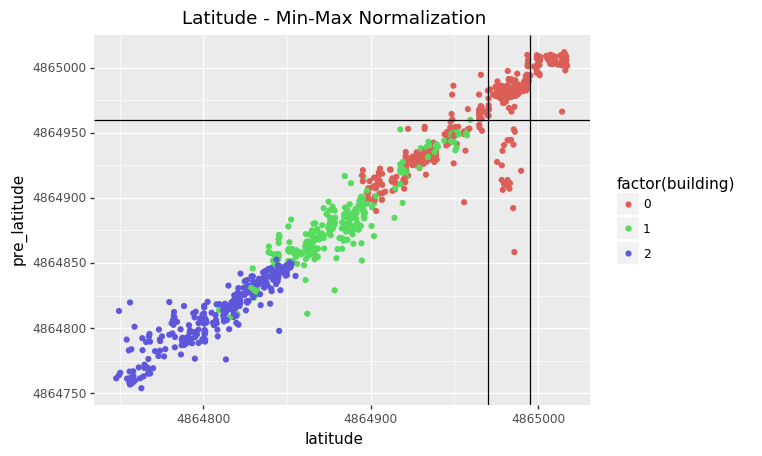

<ggplot: (7313001557)>

In [594]:
(ggplot(df, aes(x = "latitude", y = "pre_latitude", color = "factor(building)")) +
 geom_point() + labs(title = "Latitude - Min-Max Normalization") +
 geom_vline(xintercept = 4864995) +
 geom_vline(xintercept = 4864970) +
 geom_hline(yintercept = 4864960)
)

In [597]:
sus_line_index = df[(df['pre_latitude'] <4864960) & (df['latitude'] > 4864970) & (df['latitude'] < 4864995)].index

### Real position of errors

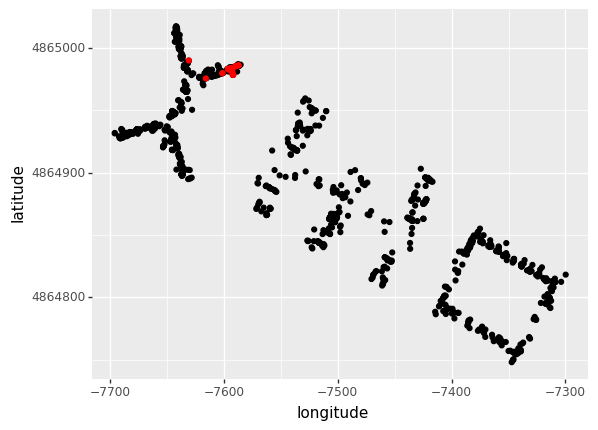

<ggplot: (7313756229)>

In [601]:
(ggplot(df, aes(x = 'longitude', y = 'latitude')) +
 geom_point()+
 geom_point(df.loc[sus_line_index], aes(x = 'longitude', y = 'latitude'), color = "red")
)

## Rotating Coordinates - Example

In [647]:
training_rot = training.copy()

In [648]:
training_rot["LONGITUDE"], training_rot["LATITUDE"] = rotate_both(training_rot["LONGITUDE"], training_rot["LATITUDE"], -29)

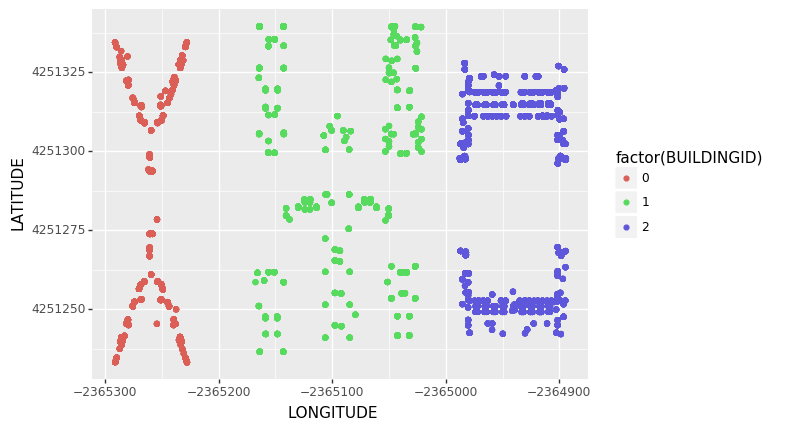

<ggplot: (7338882929)>

In [650]:
ggplot(training_rot, aes(x = "LONGITUDE", y = "LATITUDE", color = "factor(BUILDINGID)")) + geom_point()

## Latitude-Longitude Iteration 5: Rotation

* Longitute + Latitude: Random Forest
* Subset: WAP#<200
* NA Handling: 100 -> 0
* Pre-process: Log transform + Normalize + Rotation by -29 degrees

### Training Latitude model

In [713]:
data = training[WAPS_id200].copy()
# All 100 to 0, all other log_transform
data.mask(data==100, 0, inplace=True)
data.mask((data!=100) & (data !=0), 10.0**(data/10), inplace=True)

In [714]:
temp, target = rotate_both(training["LONGITUDE"], training["LATITUDE"], -29)

In [715]:
scaler = MinMaxScaler()
scaler.fit(data.T)
data = pd.DataFrame(scaler.transform(data.T).T, index = data.index, columns=data.columns)
data = data.replace(to_replace = np.nan, value = 0)

In [716]:
data_train, data_test, target_train, target_test = train_test_split(data, target, test_size = 0.30, random_state = 10)
tuned_parameters = {'n_estimators': [100], 'random_state': [123]}
latitude_model = GridSearchCV(rfr(), tuned_parameters)
latitude_model.fit(data_train, target_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n

### Training Longitude model

In [717]:
data = training[WAPS_id200].copy()
# All 100 to 0, all other log_transform
data.mask(data==100, 0, inplace=True)
data.mask((data!=100) & (data !=0), 10.0**(data/10), inplace=True)

In [718]:
target, temp = rotate_both(training["LONGITUDE"], training["LATITUDE"], -29)

In [719]:
data_train, data_test, target_train, target_test = train_test_split(data, target, test_size = 0.30, random_state = 10)
tuned_parameters = {'n_estimators': [100], 'random_state': [123]}
longitude_model = GridSearchCV(rfr(), tuned_parameters)
longitude_model.fit(data_train, target_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n

### Predicting Longitude & Latitude

In [720]:
data_vd = validation[WAPS_id200].copy()
# All 100 to 0, all other log_transform
data_vd.mask(data_vd==100, 0, inplace=True)
data_vd.mask((data_vd!=100) & (data_vd !=0), 10.0**(data_vd/10), inplace=True)

In [721]:
scaler_vd = MinMaxScaler()
scaler.fit(data_vd.T)
data_vd = pd.DataFrame(scaler.transform(data_vd.T).T, index = data_vd.index, columns=data_vd.columns)
data_vd = data_vd.replace(to_replace = np.nan, value = 0)

In [722]:
predicted_latitude_rot = latitude_model.predict(data_vd)
predicted_longitude_rot = longitude_model.predict(data_vd)
predicted_latitude_rot = pd.Series(predicted_latitude_rot, validation[WAPS_id200].index)
predicted_longitude_rot = pd.Series(predicted_longitude_rot, validation[WAPS_id200].index)

In [723]:
predicted_longitude, predicted_latitude = rotate_both(predicted_longitude_rot, predicted_latitude_rot, 29)

#### Storing in a single DF

In [724]:
df = pd.DataFrame({"pre_building": predicted_building,
                   "pre_floor": predicted_floor,
                   "pre_latitude": predicted_latitude,
                   "pre_longitude": predicted_longitude,
                   "building": validation["BUILDINGID"],
                   "floor": validation["FLOOR"],
                   "latitude": validation["LATITUDE"],
                   "longitude": validation["LONGITUDE"]})

df['err_building'] = df['building'] - df['pre_building']
df['err_floor'] = df['floor'] - df['pre_floor']
df['err_latitude'] = df['latitude'] - df['pre_latitude']
df['err_longitude'] = df['longitude'] - df['pre_longitude']
df['err_position'] = np.sqrt(df['err_longitude']**2 + df['err_latitude']**2)

### Metrics

In [725]:
met = {
    "building": {"accuracy": accuracy_score(df["building"], df["pre_building"]),
                 "kappa": cohen_kappa_score(df["building"], df["pre_building"]),
                 "confusion_matrix": confusion_matrix(df["building"], df["pre_building"])
                },
    "floor": {"accuracy": accuracy_score(df["floor"], df["pre_floor"]),
                 "kappa": cohen_kappa_score(df["floor"], df["pre_floor"]),
                 "confusion_matrix": confusion_matrix(df["floor"], df["pre_floor"])
             },
    "latitude": {"r2": r2_score(df["latitude"], df["pre_latitude"]),
                 "MAE": mean_absolute_error(df["latitude"], df["pre_latitude"]),
                 "RMSE": mean_squared_error(df["latitude"], df["pre_latitude"], squared = False),
                 "Under2m": (abs(df['err_latitude'])<2).sum()/(abs(df['err_latitude'])<2).count()*100
                },
    "longitude": {"r2": r2_score(df["longitude"], df["pre_longitude"]),
                 "MAE": mean_absolute_error(df["longitude"], df["pre_longitude"]),
                 "RMSE": mean_squared_error(df["longitude"], df["pre_longitude"], squared = False),
                 "Under2m": (abs(df['err_longitude'])<2).sum()/(abs(df['err_longitude'])<2).count()*100
                },
    "position": {"Under2m": (abs(df['err_position'])<2).sum()/(abs(df['err_position'])<2).count()*100
    }
}

In [726]:
print('''

Iteration 4 Metrics
___________________

LATITUDE
________

r2:       0.97
RMSE:     13.09
MAE:      7.16
Under 2:  30.96%

LONGITUDE
_________

r2:       0.99
RMSE:     13.28
MAE:      8.02
Under 2:  26.01%

POSITION
________

Under 2:  9.45%
''')



Iteration 4 Metrics
___________________

LATITUDE
________

r2:       0.97
RMSE:     13.09
MAE:      7.16
Under 2:  30.96%

LONGITUDE
_________

r2:       0.99
RMSE:     13.28
MAE:      8.02
Under 2:  26.01%

POSITION
________

Under 2:  9.45%



In [727]:
print("Iteration 5 Metrics")
print("___________________")

Iteration 5 Metrics
___________________


In [728]:
print("LATITUDE")
print("________")
print()
print(f"r2:       {met['latitude']['r2']:.2f}")
print(f"RMSE:     {met['latitude']['RMSE']:.2f}")
print(f"MAE:      {met['latitude']['MAE']:.2f}")
print(f"Under 2:  {met['latitude']['Under2m']:.2f}%")
print()
print("LONGITUDE")
print("_________")
print()
print(f"r2:       {met['longitude']['r2']:.2f}")
print(f"RMSE:     {met['longitude']['RMSE']:.2f}")
print(f"MAE:      {met['longitude']['MAE']:.2f}")
print(f"Under 2:  {met['longitude']['Under2m']:.2f}%")
print()
print("POSITION")
print("________")
print()
print(f"Under 2:  {met['position']['Under2m']:.2f}%")

LATITUDE
________

r2:       0.96
RMSE:     14.77
MAE:      10.66
Under 2:  16.11%

LONGITUDE
_________

r2:       0.97
RMSE:     22.04
MAE:      15.80
Under 2:  10.71%

POSITION
________

Under 2:  3.15%


### Plotting

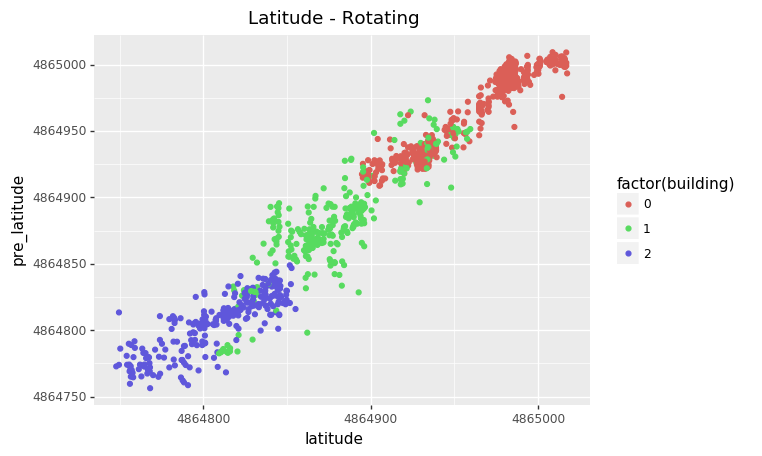

<ggplot: (7367587385)>

In [729]:
ggplot(df, aes(x = "latitude", y = "pre_latitude", color = "factor(building)")) + geom_point() + labs(title = "Latitude - Rotating")

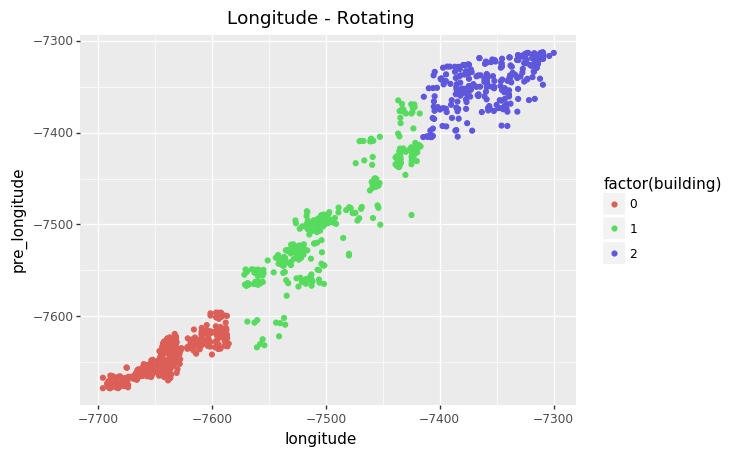

<ggplot: (7192005657)>

In [730]:
ggplot(df, aes(x = "longitude", y = "pre_longitude", color = "factor(building)")) + geom_point() + labs(title = "Longitude - Rotating")

## Final iteration - Using Building Prediction

* Building - Random Forest
* Floor - GBM
* Longitute + Latitude: Random Forest
* Subset: WAP#<200 & WAP>-50
* NA Handling: 100 -> 0
* Pre-process: Log transform + Normalize + Rotation by -29 degrees

### Training Building prediction model

In [668]:
data = training[WAPS_50_id200]
target = training["BUILDINGID"]

In [669]:
data_train, data_test, target_train, target_test = train_test_split(data, target, test_size = 0.30, random_state = 10)

In [670]:
tuned_parameters = {"n_estimators": [10], "random_state": [123]}

In [671]:
building_model = GridSearchCV(rfc(), tuned_parameters)

In [672]:
building_model.fit(data_train, target_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              ra

### Predicting Building

In [673]:
data_vd = validation[WAPS_50_id200]

In [674]:
predicted_building = building_model.predict(data_vd)

### Splitting the dataset per building

In [675]:
validation["pre_building"] = predicted_building

In [676]:
tr_bg0 = training[training["BUILDINGID"] == 0]
tr_bg1 = training[training["BUILDINGID"] == 1]
tr_bg2 = training[training["BUILDINGID"] == 2]

In [677]:
building_dict = {"0": tr_bg0, "1": tr_bg1, "2": tr_bg2}

In [678]:
vd_bg0 = validation[validation["pre_building"] == 0]
vd_bg1 = validation[validation["pre_building"] == 1]
vd_bg2 = validation[validation["pre_building"] == 2]

In [679]:
building_dict_vd = {"0": vd_bg0, "1": vd_bg1, "2": vd_bg2}

### Training floor per predicted building

In [680]:
floor_model_dict = {}
for num in building_dict:
    data = building_dict[num][WAPS_id200].copy()
    target = building_dict[num]["FLOOR"]
    data = data.replace(to_replace = 100, value = -105)  # replacing all 100 values with -105
    data = data-100   # shifting all values by -100, to avoid division by 0
    data = data.apply(to_perc_neg, axis =1, args=[-205])  # normalizing all values as percentage of maximum value in row
    data_train, data_test, target_train, target_test = train_test_split(data, target, test_size = 0.30, random_state = 10)
    floor_model = gbc(n_estimators = 100, learning_rate = 0.1, random_state = 123)
    floor_model.fit(data_train, target_train)
    floor_model_dict[num] = floor_model

### Predicting Floor

In [681]:
predicted_floor_dic = {}
for num in building_dict_vd:
    data_vd = building_dict_vd[num][WAPS_id200].copy()
    data_vd = data_vd.replace(to_replace = 100, value = -105) # replacing all 100 values with -105
    data_vd = data_vd-100   # shifting all values by -100, to avoid division by 0
    data_vd = data_vd.apply(to_perc_neg, axis =1, args=[-205]) # normalizing all values as percentage of maximum value in row
    predicted_floor = floor_model_dict[num].predict(data_vd)
    predicted_floor_dic[num] = predicted_floor

In [682]:
predicted_floor_dic["0"] = pd.Series(predicted_floor_dic["0"], vd_bg0.index)
predicted_floor_dic["1"] = pd.Series(predicted_floor_dic["1"], vd_bg1.index)
predicted_floor_dic["2"] = pd.Series(predicted_floor_dic["2"], vd_bg2.index)

In [683]:
predicted_floor = pd.concat([predicted_floor_dic["0"], predicted_floor_dic["1"], predicted_floor_dic["2"]]).sort_index()   

### Training Latitude model - per building

In [684]:
lat_model_dict = {}
for num in building_dict:
    data = building_dict[num][WAPS_50_id200].copy()
    temp, target = rotate_both(building_dict[num]["LONGITUDE"], building_dict[num]["LATITUDE"], -29)
    # All 100 to -10, al other log_transform
    data.mask(data==100, -10, inplace=True) 
    data.mask((data!=100) & (data !=-10), 10.0**(data/10), inplace=True)
    # normalizing all values as percentage of maximum value in row
    data = data.apply(to_perc, axis =1, args=[-10])
    # Train test split
    data_train, data_test, target_train, target_test = train_test_split(data, target, test_size = 0.30, random_state = 10)
    # Grid parameters
    tuned_parameters = {'n_estimators': [100], 'random_state': [123]}
    # Training the model
    latitude_model = GridSearchCV(rfr(), tuned_parameters)
    latitude_model.fit(data_train, target_train)
    # Saving in dict
    lat_model_dict[num] = latitude_model

### Training Longitude model - per building

In [685]:
lon_model_dict = {}
for num in building_dict:
    data = building_dict[num][WAPS_50_id200].copy()
    target, temp = rotate_both(building_dict[num]["LONGITUDE"], building_dict[num]["LATITUDE"], -29)
    # All 100 to -10, all other log_transform
    data.mask(data==100, -10, inplace=True) 
    data.mask((data!=100) & (data !=-10), 10.0**(data/10), inplace=True)
    # normalizing all values as percentage of maximum value in row
    data = data.apply(to_perc, axis =1, args=[-10])
    # Train test split
    data_train, data_test, target_train, target_test = train_test_split(data, target, test_size = 0.30, random_state = 10)
    # Grid parameters
    tuned_parameters = {'n_estimators': [100], 'random_state': [123]}
    # Training the model
    longitude_model = GridSearchCV(rfr(), tuned_parameters)
    longitude_model.fit(data_train, target_train)
    # Saving in dict
    lon_model_dict[num] = longitude_model

### Predicting Latitude and Longitude

In [686]:
# # selecting subset of WAPs
# data_vd = validation[WAPS_50_id200].copy()

# # All 100 to -10, all other log_transform
# data_vd.mask(data_vd==100, -10, inplace=True)
# data_vd.mask((data_vd!=100) & (data_vd !=-10), 10.0**(data_vd/10), inplace=True)

# # normalizing all values as percentage of maximum value in row
# data_vd = data_vd.apply(to_perc, axis =1, args=[-10])

data_vd_all = pd.read_pickle("/Users/tslilstrauss/Google Drive/Strawberry Plate/Data Analysis/Ubiqum Data Analysis/WiFi/Data/Clean/data_vd_WAP>-50_WAP#<194_log_norm.pkl")

In [687]:
predicted_lat_dic = {}
predicted_lon_dic = {}
for num in building_dict_vd:
    data_vd = data_vd_all.loc[building_dict_vd[num].index]
    predicted_lat_dic[num] = lat_model_dict[num].predict(data_vd.loc[building_dict_vd[num].index])
    predicted_lon_dic[num] = lon_model_dict[num].predict(data_vd.loc[building_dict_vd[num].index])
    predicted_lat_dic[num] = pd.Series(predicted_lat_dic[num], building_dict_vd[num].index)
    predicted_lon_dic[num] = pd.Series(predicted_lon_dic[num], building_dict_vd[num].index)

In [688]:
pre_latitude_rot = pd.concat([predicted_lat_dic["0"], predicted_lat_dic["1"], predicted_lat_dic["2"]])
pre_longitude_rot = pd.concat([predicted_lon_dic["0"], predicted_lon_dic["1"], predicted_lon_dic["2"]])

In [689]:
validation["pre_latitude_rot"] = pre_latitude_rot
validation["pre_longitude_rot"] = pre_longitude_rot

In [690]:
predicted_longitude, predicted_latitude = rotate_both(validation["pre_longitude_rot"], validation["pre_latitude_rot"], 29)

#### Storing in a single DF

In [691]:
df = pd.DataFrame({"pre_building": predicted_building,
                   "pre_floor": predicted_floor,
                   "pre_latitude": predicted_latitude,
                   "pre_longitude": predicted_longitude,
                   "building": validation["BUILDINGID"],
                   "floor": validation["FLOOR"],
                   "latitude": validation["LATITUDE"],
                   "longitude": validation["LONGITUDE"]})

In [692]:
df['err_building'] = df['building'] - df['pre_building']
df['err_floor'] = df['floor'] - df['pre_floor']
df['err_latitude'] = df['latitude'] - df['pre_latitude']
df['err_longitude'] = df['longitude'] - df['pre_longitude']
df['err_position'] = np.sqrt(df['err_longitude']**2 + df['err_latitude']**2)

### Metrics

In [693]:
met = {
    "building": {"accuracy": accuracy_score(df["building"], df["pre_building"]),
                 "kappa": cohen_kappa_score(df["building"], df["pre_building"]),
                 "confusion_matrix": confusion_matrix(df["building"], df["pre_building"])
                },
    "floor": {"accuracy": accuracy_score(df["floor"], df["pre_floor"]),
                 "kappa": cohen_kappa_score(df["floor"], df["pre_floor"]),
                 "confusion_matrix": confusion_matrix(df["floor"], df["pre_floor"])
             },
    "latitude": {"r2": r2_score(df["latitude"], df["pre_latitude"]),
                 "MAE": mean_absolute_error(df["latitude"], df["pre_latitude"]),
                 "RMSE": mean_squared_error(df["latitude"], df["pre_latitude"], squared = False),
                 "Under2m": (abs(df['err_latitude'])<2).sum()/(abs(df['err_latitude'])<2).count()*100
                },
    "longitude": {"r2": r2_score(df["longitude"], df["pre_longitude"]),
                 "MAE": mean_absolute_error(df["longitude"], df["pre_longitude"]),
                 "RMSE": mean_squared_error(df["longitude"], df["pre_longitude"], squared = False),
                 "Under2m": (abs(df['err_longitude'])<2).sum()/(abs(df['err_longitude'])<2).count()*100
                },
    "position": {"Under2m": (abs(df['err_position'])<2).sum()/(abs(df['err_position'])<2).count()*100
    }
}

In [694]:
print("BUILDING")
print("________")
print()
print(f"Accuracy: {met['building']['accuracy']:.2f}")
print(f"Kappa:    {met['building']['kappa']:.2f}")
print()
print(f"Confusion Matrix: \n\n{met['building']['confusion_matrix']}")
print()
print("FLOOR")
print("______")
print()
print(f"Accuracy: {met['floor']['accuracy']:.2f}")
print(f"Kappa:    {met['floor']['kappa']:.2f}")
print()
print(f"Confusion Matrix: \n\n{met['floor']['confusion_matrix']}")
print()
print("LATITUDE")
print("________")
print()
print(f"r2:       {met['latitude']['r2']:.2f}")
print(f"RMSE:     {met['latitude']['RMSE']:.2f}")
print(f"MAE:      {met['latitude']['MAE']:.2f}")
print(f"Under 2:  {met['latitude']['Under2m']:.2f}%")
print()
print("LONGITUDE")
print("_________")
print()
print(f"r2:       {met['longitude']['r2']:.2f}")
print(f"RMSE:     {met['longitude']['RMSE']:.2f}")
print(f"MAE:      {met['longitude']['MAE']:.2f}")
print(f"Under 2:  {met['longitude']['Under2m']:.2f}%")
print()
print("POSITION")
print("________")
print(f"Under 2: {met['position']['Under2m']:.2f}%")

BUILDING
________

Accuracy: 1.00
Kappa:    1.00

Confusion Matrix: 

[[535   1   0]
 [  0 306   1]
 [  0   0 268]]

FLOOR
______

Accuracy: 0.94
Kappa:    0.92

Confusion Matrix: 

[[119  12   1   0   0]
 [ 14 441   5   2   0]
 [  2  10 286   8   0]
 [  0   0   3 167   2]
 [  2   1   0   5  31]]

LATITUDE
________

r2:       0.98
RMSE:     10.68
MAE:      6.51
Under 2:  30.06%

LONGITUDE
_________

r2:       0.99
RMSE:     11.87
MAE:      7.37
Under 2:  28.80%

POSITION
________
Under 2: 10.53%


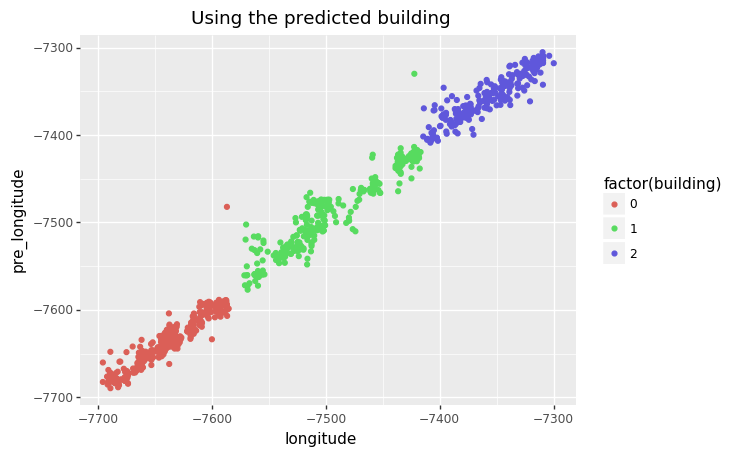

<ggplot: (7186448021)>

In [701]:
ggplot(df, aes(x = "longitude", y = "pre_longitude", color = "factor(building)")) + geom_point() + labs(title = "Using the predicted building")

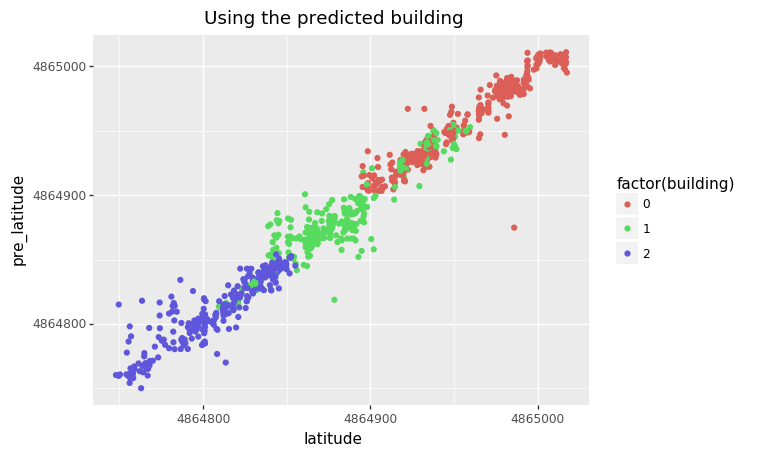

<ggplot: (7353879821)>

In [702]:
ggplot(df, aes(x = "latitude", y = "pre_latitude", color = "factor(building)")) + geom_point() + labs(title = "Using the predicted building")

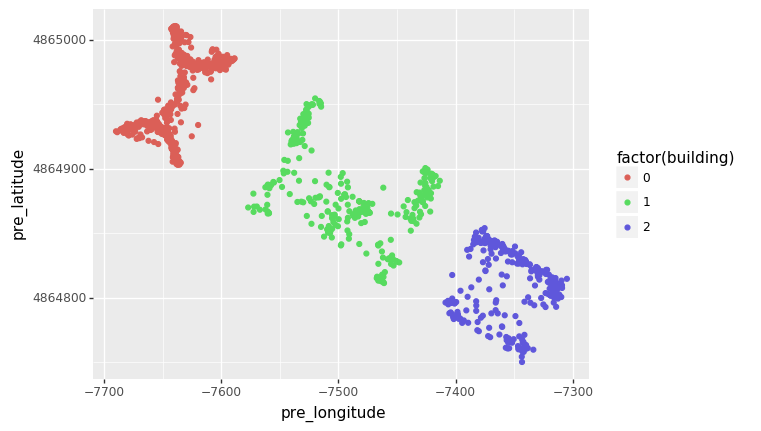

<ggplot: (7358745189)>

In [703]:
ggplot(df, aes(x = "pre_longitude", y = "pre_latitude", color = "factor(building)")) + geom_point()

## Possible Next Steps

* More distinct WAP Subsets - personalized
* Subseting rows in training set
* Creating a "Space" location prediction
* Further investigation into errors and models - specifically which is better at what - to continue optimizing
* Creating a parallel model prediction with a joint confidence score